In [1]:
%pylab inline
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim

from torch.utils.data import TensorDataset
from torch.autograd import Variable
from torchvision import transforms
from torchvision.datasets import MNIST, CIFAR10
from tqdm import tqdm
import sys, os
import pickle
import cv2

SEED = 1

# CUDA?
cuda = torch.cuda.is_available()

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

Populating the interactive namespace from numpy and matplotlib


In [24]:
# Create DataLoader
# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])
transform = transforms.ToTensor()

train = CIFAR10('./data', train=True, download=True, transform=transform)
test = CIFAR10('./data', train=False, download=True, transform=transform)

dataloader_args = dict(batch_size=256,num_workers=4, 
                       pin_memory=True) if cuda else dict(batch_size=64)
train_loader = dataloader.DataLoader(train, shuffle=True, **dataloader_args)
test_loader = dataloader.DataLoader(test, shuffle=False, **dataloader_args)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
num_cls = len(classes)
p = next(iter(train_loader))[0].shape[-1]
print('class number: {}'.format(num_cls))
print('image size: {}'.format(p))

Files already downloaded and verified
Files already downloaded and verified
class number: 10
image size: 32


In [3]:
class Model(nn.Module):
    def __init__(self, p):
        super(Model, self).__init__()

        self.conv1 = nn.Sequential(
            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=p, kernel_size=3, padding=1),
            nn.BatchNorm2d(p),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=p, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Sequential(
            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool2 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05)
        )

        self.conv3 = nn.Sequential(
            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc_layer1 = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True)
        )
        self.fc_layer2 = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(512, 10)
        )


    def forward(self, x):
        """Perform forward."""
        
        # conv layers
        x_conv1 = self.conv1(x)
        x_conv2 = self.conv2(self.pool1(x_conv1))
        x_conv3 = self.conv3(self.pool2(x_conv2))
        x1 = self.pool3(x_conv3)
        
        # flatten
        x2 = x1.view(x1.size(0), -1)
        
        # fc layer
        x3 = self.fc_layer1(x2)
        x4 = self.fc_layer2(x3)

        return x4, x3, x_conv3, x_conv2, x_conv1
      
model = Model(p)
if cuda:
    model.cuda() # CUDA!
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [8]:
# Model without batchnorm and dropout
class Model(nn.Module):
    def __init__(self, p):
        super(Model, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=p, kernel_size=3, padding=1) #RF=3
        self.conv2 = nn.Conv2d(in_channels=p, out_channels=64, kernel_size=3, padding=1) #RF=5

        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) #RF=10
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1) #RF=12
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1) #RF=14

        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) #RF=28
        
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1) #RF=30
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1) #RF=32 (maxed out)

        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) 

        self.fc_layer1 = nn.Linear(4096, 1024)
        self.fc_layer2 = nn.Linear(1024, 512)
        self.fc_layer3 = nn.Linear(512, 10)

    def forward(self, x):
        """Perform forward."""
        
#         # conv layers -- relu
#         x_conv1 = F.relu(self.conv1(x), inplace=True)
#         x_conv2 = F.relu(self.conv2(x_conv1), inplace=True)
        
#         x_conv3 = F.relu(self.conv3(self.pool1(x_conv2)), inplace=True)
#         x_conv4 = F.relu(self.conv4(x_conv3), inplace=True)
        
#         x_conv5 = F.relu(self.conv5(self.pool2(x_conv4)), inplace=True)
#         x_conv6 = F.relu(self.conv6(x_conv5), inplace=True)
        
        # conv layers -- tanh
        x_conv1 = torch.tanh(self.conv1(x))
        x_conv2 = torch.tanh(self.conv2(x_conv1))
        
        x_conv3 = torch.tanh(self.conv3(self.pool1(x_conv2)))
        x_conv4 = torch.tanh(self.conv4(x_conv3))
        
        x_conv5 = torch.tanh(self.conv5(self.pool2(x_conv4)))
        x_conv6 = torch.tanh(self.conv6(x_conv5))
        
        x1 = self.pool3(x_conv6)
        
        # flatten
        x2 = x1.view(x1.size(0), -1)
        
        # fc layers
        x3 = F.relu(self.fc_layer1(x2), inplace=True)
        x4 = F.relu(self.fc_layer2(x3), inplace=True)
        x5 = self.fc_layer3(x4)

        return x5, x4, x_conv6, x_conv4, x_conv2, x_conv1
      
model = Model(p)
if cuda:
    model.cuda() # CUDA!
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [4]:
save_path = 'cache/models'

In [9]:
EPOCHS = 15
losses = []

best_acc = 0
for epoch in range(EPOCHS):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        
        optimizer.zero_grad()
        # Predict
        y_pred = model(data)[0]

        # Calculate loss
        loss = F.cross_entropy(y_pred, target)
        losses.append(loss.cpu().data)      
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        
        # Display
        if batch_idx % 100 == 1:
            print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                  epoch+1,
                  EPOCHS,
                  batch_idx * len(data),
                  len(train_loader.dataset),
                  100. * batch_idx / len(train_loader), 
                  loss.cpu().data), 
                  end='')
    # Eval
    model.eval()
    hit = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            if cuda:
                data, target = data.cuda(), target.cuda()
                pred = model(data)[0].max(1)[1]
                hit += pred.eq(target).cpu().sum()
                total += len(target)
    accuracy = hit.type(dtype=torch.float64)/total
    
    # save best
    if accuracy > best_acc:
        best_acc = accuracy
        torch.save({'epoch': epoch,
                  'model': model.state_dict(),
                  'optimizer': optimizer.state_dict()
                 }, '{}/epoch_{}.pth'.format(save_path, epoch))
        print('\r Best model saved.\r')
      
    print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Test Accuracy: {:.4f}%'.format(
        epoch+1,
        EPOCHS,
        len(train_loader.dataset), 
        len(train_loader.dataset),
        100. * batch_idx / len(train_loader), 
        loss.cpu().data,
        accuracy*100,
        end=''))

 Best model saved. [25856/50000 (52%)]	Loss: 1.745583
 Train Epoch: 1/15 [50000/50000 (20%)]	Loss: 1.506590	 Test Accuracy: 46.0000%
 Best model saved. [25856/50000 (52%)]	Loss: 1.208642
 Train Epoch: 2/15 [50000/50000 (20%)]	Loss: 1.004856	 Test Accuracy: 58.3800%
 Best model saved. [25856/50000 (52%)]	Loss: 0.936191
 Train Epoch: 3/15 [50000/50000 (20%)]	Loss: 0.705756	 Test Accuracy: 66.6500%
 Best model saved. [25856/50000 (52%)]	Loss: 0.759976
 Train Epoch: 4/15 [50000/50000 (20%)]	Loss: 0.866510	 Test Accuracy: 70.5300%
 Best model saved. [25856/50000 (52%)]	Loss: 0.592977
 Train Epoch: 5/15 [50000/50000 (20%)]	Loss: 0.544680	 Test Accuracy: 73.4800%
 Best model saved. [25856/50000 (52%)]	Loss: 0.419431
 Train Epoch: 6/15 [50000/50000 (20%)]	Loss: 0.617280	 Test Accuracy: 73.8300%
 Best model saved. [25856/50000 (52%)]	Loss: 0.353487
 Train Epoch: 7/15 [50000/50000 (20%)]	Loss: 0.333927	 Test Accuracy: 74.6400%
 Best model saved. [25856/50000 (52%)]	Loss: 0.168928
 Train Epoch: 8

In [5]:
# Load and use the best model
# bst_mdl = save_path+'/best_nodrop_tanh.pth'
bst_mdl = save_path+'/ad_model.pth'
# bst_mdl = save_path+'/best_drop.pth'
model.load_state_dict(torch.load(bst_mdl)['model'])

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [6]:
 model.state_dict().keys()

odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'conv3.weight', 'conv3.bias', 'conv4.weight', 'conv4.bias', 'conv5.weight', 'conv5.bias', 'conv6.weight', 'conv6.bias', 'fc_layer1.weight', 'fc_layer1.bias', 'fc_layer2.weight', 'fc_layer2.bias', 'fc_layer3.weight', 'fc_layer3.bias'])

torch.Size([32, 3, 3, 3])


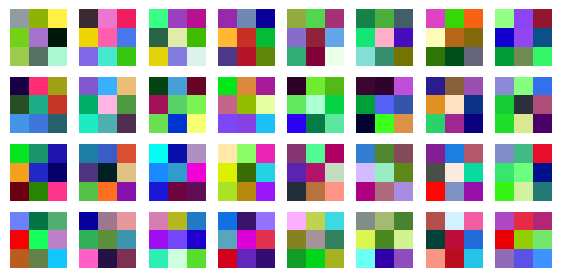

In [11]:
w_ = model.state_dict()['conv1.weight']
print(w_.shape)

figure(num=None, figsize=(7, 7), dpi=100, facecolor='w', edgecolor='k')
for i in range(w_.shape[0]):
    plt.subplot(8, 8, i+1)
    plt.axis('off')
    to_show = w_[i].permute(1,2,0).cpu().numpy()
    plt.imshow((to_show - to_show.min())/(to_show.max() - to_show.min()))
plt.show()

In [14]:
# get white-noise activation
batch_size = 250
all_size = 100000#100000
iters = 1 #100
stats = {} # recording the bias
fc_act_noise = {}
conv3_act_noise = {}
conv2_act_noise = {}
conv1_act_noise = {}
noise = {}

for i in range(num_cls):
    stats[i] = 0
    fc_act_noise[i] = []
    conv3_act_noise[i] = []
    conv2_act_noise[i] = []
    conv1_act_noise[i] = []
    noise[i] = []

for kk in range(iters):
    print(kk)
    z = torch.rand(all_size, 3, p, p)
#     z = torch.from_numpy(np.load('data/whitenoise{}.npy'.format(kk)))
    with tqdm(total=all_size//batch_size, file=sys.stdout) as pbar:
        for k in range(0, all_size, batch_size):
            with torch.no_grad():
                cur_data = z[k:k+batch_size]
                if cuda:
                    cur_data = cur_data.cuda()
                out, fc_out, conv3_out, conv2_out, conv1_out = model(cur_data)
#                 out, fc_out, conv_out = model(torch.rand(batch_size, 3, p, p).cuda())
            pred = out.max(1)[1]
            for i in range(num_cls):
                fc_act_noise[i].append(fc_out[pred == i].cpu())
                conv3_act_noise[i].append(conv3_out[pred == i].cpu())
                conv2_act_noise[i].append(conv2_out[pred == i].cpu())
                conv1_act_noise[i].append(conv1_out[pred == i].cpu())
                noise[i].append(cur_data[pred == i].cpu())
                stats[i] += (pred == i).sum()
            pbar.update(1)
            
    np.save('data/whitenoise{}.npy'.format(kk), z)
# import pdb; pdb.set_trace()
for i in range(num_cls):
    fc_act_noise[i] = torch.cat(fc_act_noise[i]).reshape(-1, 32, 16).mean(0)
    conv3_act_noise[i] = torch.cat(conv3_act_noise[i]).mean(0) #average over samples
    conv2_act_noise[i] = torch.cat(conv2_act_noise[i]).mean(0)
    conv1_act_noise[i] = torch.cat(conv1_act_noise[i]).mean(0)
    noise[i] = torch.cat(noise[i]).mean(0)

# save noise activation results
noise_acts = {}
noise_acts['fc'] = fc_act_noise
noise_acts['conv3'] = conv3_act_noise
noise_acts['conv2'] = conv2_act_noise
noise_acts['conv1'] = conv1_act_noise
noise_acts['img'] = noise
noise_acts['stats'] = stats

with open('cache/noise_acts10.pkl', 'wb') as f: 
    pickle.dump(noise_acts, f)

0
100%|██████████| 400/400 [06:54<00:00,  1.05s/it]


In [6]:
# load noise activation results
with open('cache/noise_acts.pkl', 'rb') as f:
    noise_acts = pickle.load(f)
fc_act_noise = noise_acts['fc']
conv3_act_noise = noise_acts['conv3']
conv2_act_noise = noise_acts['conv2']
conv1_act_noise = noise_acts['conv1']
noise = noise_acts['img']
noise_acts.keys()

dict_keys(['fc', 'conv3', 'conv2', 'conv1', 'img'])

In [3]:
# loading noise act from multiple files
file_num = 10
fc_act_noise = {}
conv3_act_noise = {}
conv2_act_noise = {}
conv1_act_noise = {}
noise = {}

for i in range(num_cls):
    fc_act_noise[i] = []
    conv3_act_noise[i] = []
    conv2_act_noise[i] = []
    conv1_act_noise[i] = []
    noise[i] = []

for i in range(1, file_num+1):
    with open('cache/noise_acts{}.pkl'.format(i), 'rb') as f:
        cur_data = pickle.load(f)
    fc_act = cur_data['fc']
    conv3_act = cur_data['conv3']
    conv2_act = cur_data['conv2']
    conv1_act = cur_data['conv1']
    noise_img = cur_data['img']
    for k in range(num_cls):
        fc_act_noise[k].append(fc_act[k][None, ...])
        conv3_act_noise[k].append(conv3_act[k][None, ...])
        conv2_act_noise[k].append(conv2_act[k][None, ...])
        conv1_act_noise[k].append(conv1_act[k][None, ...])
        noise[k].append(noise_img[k][None, ...])

for i in range(num_cls):
    fc_act_noise[i] = torch.cat(fc_act_noise[i]).mean(0)
    conv3_act_noise[i] = torch.cat(conv3_act_noise[i]).mean(0)
    conv2_act_noise[i] = torch.cat(conv2_act_noise[i]).mean(0)
    conv1_act_noise[i] = torch.cat(conv1_act_noise[i]).mean(0)
    noise[i] = torch.cat(noise[i]).mean(0)


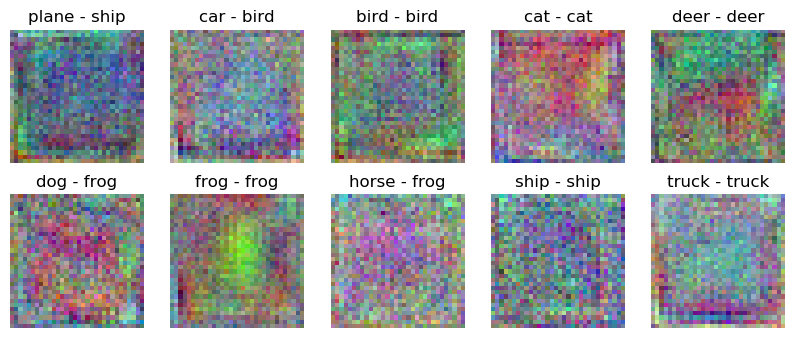

In [12]:
model.eval()
with torch.no_grad():
    figure(num=None, figsize=(10, 4), dpi=100, facecolor='w', edgecolor='k')
    for i in range(num_cls):
        a = noise[i]
        a = (a - a.min()) / (a.max() - a.min())
        pred = model(a[None, ...].cuda())[0].max(1)[1].cpu().numpy()[0]
        
        plt.subplot(2, 5, i+1)
        plt.axis('off')
        plt.title(f'{classes[i]} - {classes[pred]}')
        plt.imshow(a.permute(1,2,0), cmap='jet')

In [4]:
# activation of white noise average
pred_noise_avg = []
fc_act_noise_avg = {}
conv3_act_noise_avg = {}
conv2_act_noise_avg = {}
conv1_act_noise_avg = {}
for i in range(num_cls):
    with torch.no_grad():
        cur_avg_noise = noise[i][None, ...]
        if cuda:
            cur_avg_noise = cur_avg_noise.cuda()
        out_noise_avg, fc_act_noise_avg[i], conv3_act_noise_avg[i], \
        conv2_act_noise_avg[i], conv1_act_noise_avg[i] = model(cur_avg_noise)
        
    pred_noise_avg.append(out_noise_avg.max(1)[1].cpu().numpy()[0])
    fc_act_noise_avg[i] = fc_act_noise_avg[i][0].reshape(32, 16).cpu()
    conv3_act_noise_avg[i] = conv3_act_noise_avg[i][0].cpu()
    conv2_act_noise_avg[i] = conv2_act_noise_avg[i][0].cpu()
    conv1_act_noise_avg[i] = conv1_act_noise_avg[i][0].cpu()
    
pred_noise_avg

NameError: name 'model' is not defined

In [13]:
# check model activation pattern on real images (training data)
# gt based
fc_act_gt = {}
conv3_act_gt = {}
conv2_act_gt = {}
conv1_act_gt = {}
# pred based
fc_act_pred = {}
conv3_act_pred = {}
conv2_act_pred = {}
conv1_act_pred = {}

for i in range(num_cls):
    fc_act_gt[i] = []
    fc_act_pred[i] = []
    conv3_act_gt[i] = []
    conv3_act_pred[i] = []
    conv2_act_gt[i] = []
    conv2_act_pred[i] = []
    conv1_act_gt[i] = []
    conv1_act_pred[i] = []

with torch.no_grad():
    with tqdm(len(train_loader), file=sys.stdout) as pbar:
        for batch_idx, (data, target) in enumerate(train_loader):
            if cuda:
                data, target = data.cuda(), target.cuda()
            out, fc_out, conv3_out, conv2_out, conv1_out = model(data)
            pred = out.max(1)[1]

            for i in range(num_cls):
                fc_act_gt[i].append(fc_out[target == i].cpu())
                fc_act_pred[i].append(fc_out[pred == i].cpu())
                conv3_act_gt[i].append(conv3_out[target == i].cpu())
                conv3_act_pred[i].append(conv3_out[pred == i].cpu())
                conv2_act_gt[i].append(conv2_out[target == i].cpu())
                conv2_act_pred[i].append(conv2_out[pred == i].cpu())
                conv1_act_gt[i].append(conv1_out[target == i].cpu())
                conv1_act_pred[i].append(conv1_out[pred == i].cpu())
            pbar.update(1)

for i in range(num_cls):
    fc_act_gt[i] = torch.cat(fc_act_gt[i]).reshape(-1, 32, 16).mean(0)
    fc_act_pred[i] = torch.cat(fc_act_pred[i]).reshape(-1, 32, 16).mean(0)
    conv3_act_gt[i] = torch.cat(conv3_act_gt[i]).mean(0)
    conv2_act_gt[i] = torch.cat(conv2_act_gt[i]).mean(0)
    conv1_act_gt[i] = torch.cat(conv1_act_gt[i]).mean(0)
    conv3_act_pred[i] = torch.cat(conv3_act_pred[i]).mean(0)
    conv2_act_pred[i] = torch.cat(conv2_act_pred[i]).mean(0)
    conv1_act_pred[i] = torch.cat(conv1_act_pred[i]).mean(0)

# save training data activation results
train_data_acts = {}
train_data_acts['fc_gt'] = fc_act_gt
train_data_acts['conv3_gt'] = conv3_act_gt
train_data_acts['conv2_gt'] = conv2_act_gt
train_data_acts['conv1_gt'] = conv1_act_gt
train_data_acts['fc_pred'] = fc_act_pred
train_data_acts['conv3_pred'] = conv3_act_pred
train_data_acts['conv2_pred'] = conv2_act_pred
train_data_acts['conv1_pred'] = conv1_act_pred

with open('cache/train_data_acts.pkl', 'wb') as f: 
    pickle.dump(train_data_acts, f)

196it [03:55,  1.16s/it]


In [26]:
# load activation on training data
with open('cache/train_data_acts.pkl', 'rb') as f:
    train_data_acts = pickle.load(f)
fc_act_gt = train_data_acts['fc_gt']
conv3_act_gt = train_data_acts['conv3_gt']
conv2_act_gt = train_data_acts['conv2_gt']
conv1_act_gt = train_data_acts['conv1_gt']
fc_act_pred = train_data_acts['fc_pred']
conv3_act_pred = train_data_acts['conv3_pred']
conv2_act_pred = train_data_acts['conv2_pred']
conv1_act_pred = train_data_acts['conv1_pred']
train_data_acts.keys()

dict_keys(['fc_gt', 'conv3_gt', 'conv2_gt', 'conv1_gt', 'fc_pred', 'conv3_pred', 'conv2_pred', 'conv1_pred'])

In [230]:
train_data_img = {}
for i in range(num_cls):
    train_data_img[i] = []
for batch_idx, (data, target) in enumerate(train_loader):
    for i in range(num_cls):
        train_data_img[i].append(data[target==i])

for i in range(num_cls):
    train_data_img[i] = torch.cat(train_data_img[i]).mean(0)

train_data_img[0].shape

torch.Size([3, 32, 32])

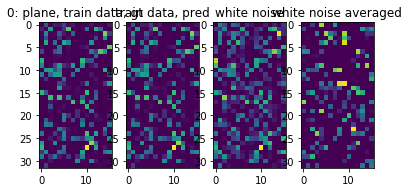

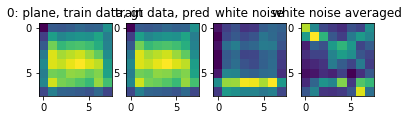

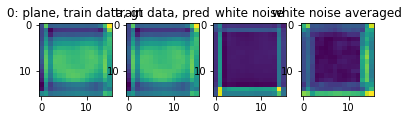

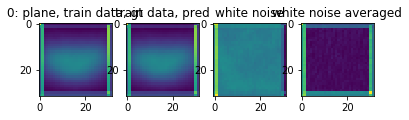

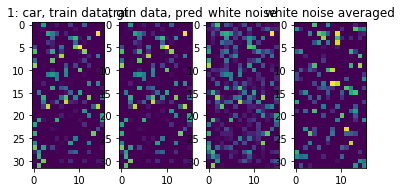

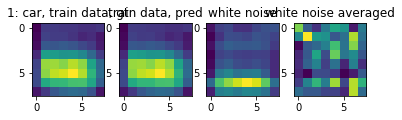

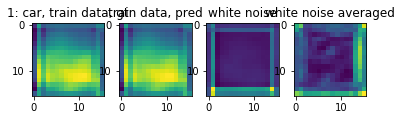

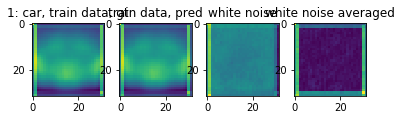

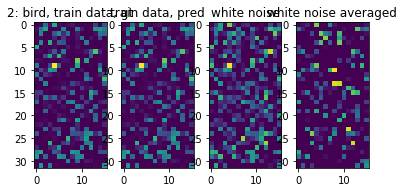

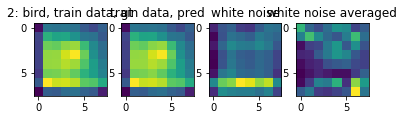

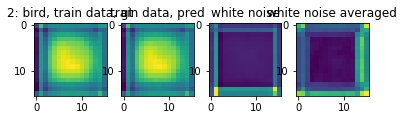

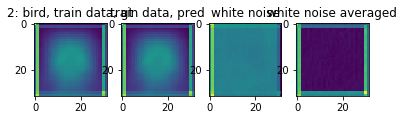

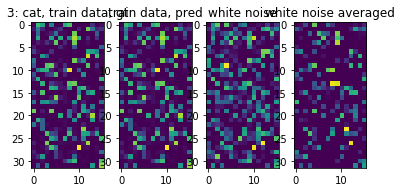

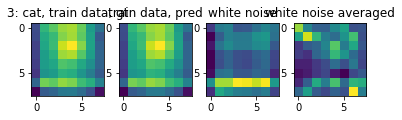

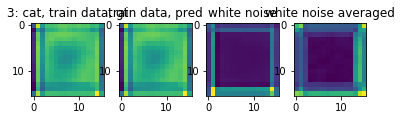

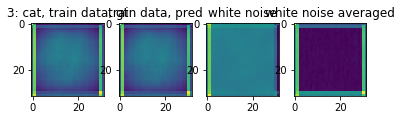

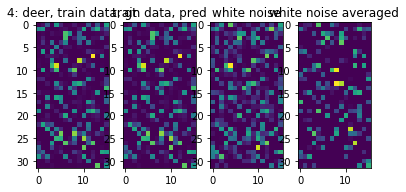

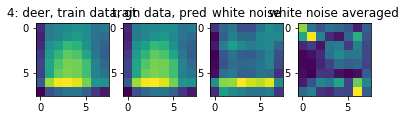

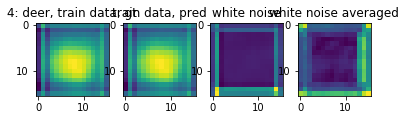

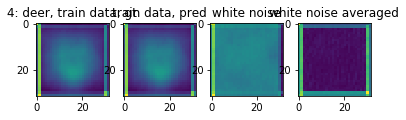

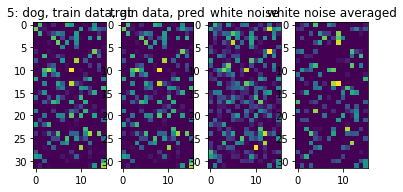

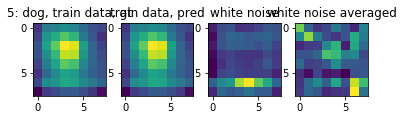

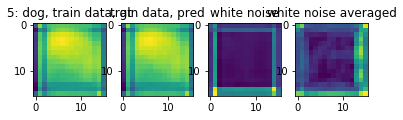

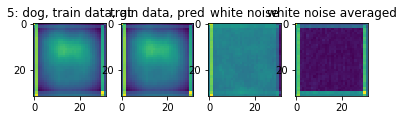

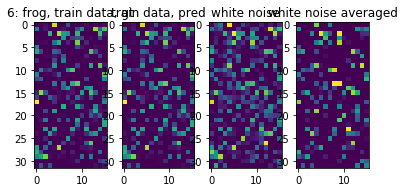

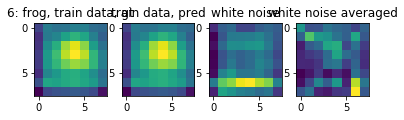

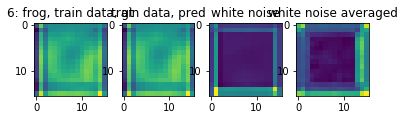

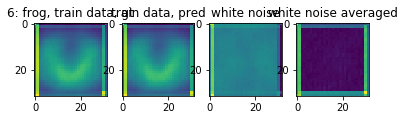

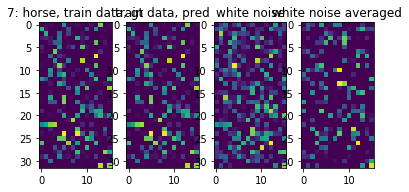

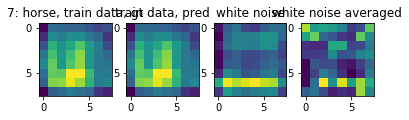

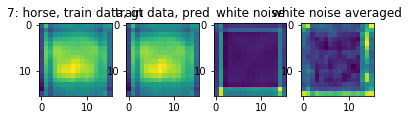

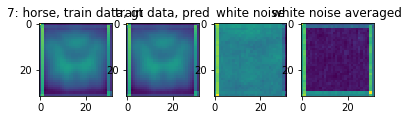

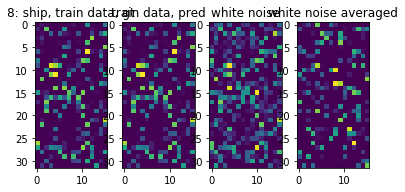

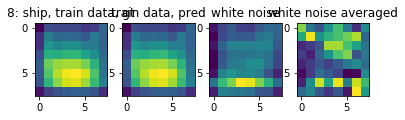

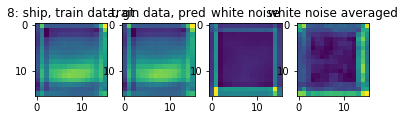

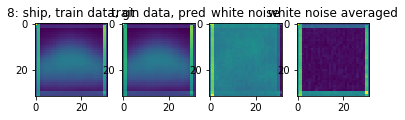

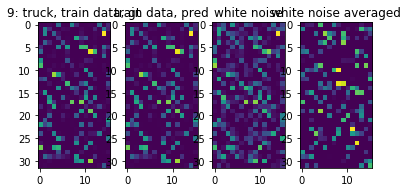

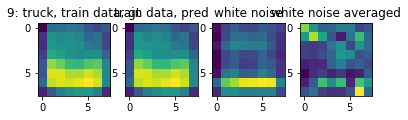

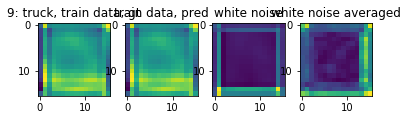

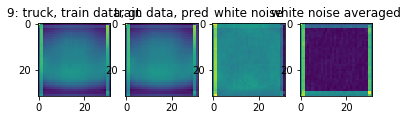

In [9]:
for i in range(num_cls):
    plt.subplot(1, 4, 1)
    plt.title('{}: {}, train data, gt'.format(i, classes[i]))
    plt.imshow(fc_act_gt[i].numpy())
    plt.subplot(1, 4, 2)
    plt.title('train data, pred')
    plt.imshow(fc_act_pred[i].numpy())
    plt.subplot(1, 4, 3)
    plt.title('white noise')
    plt.imshow(fc_act_noise[i].numpy())
    plt.subplot(1, 4, 4)
    plt.title('white noise averaged')
    plt.imshow(fc_act_noise_avg[i].numpy())
    plt.show()
    
    plt.subplot(1, 4, 1)
    plt.title('{}: {}, train data, gt'.format(i, classes[i]))
    plt.imshow(conv3_act_gt[i].mean(0).numpy())
    plt.subplot(1, 4, 2)
    plt.title('train data, pred')
    plt.imshow(conv3_act_pred[i].mean(0).numpy())
    plt.subplot(1, 4, 3)
    plt.title('white noise')
    plt.imshow(conv3_act_noise[i].mean(0).numpy())
    plt.subplot(1, 4, 4)
    plt.title('white noise averaged')
    plt.imshow(conv3_act_noise_avg[i].mean(0).numpy())
    plt.show()
    
    plt.subplot(1, 4, 1)
    plt.title('{}: {}, train data, gt'.format(i, classes[i]))
    plt.imshow(conv2_act_gt[i].mean(0).numpy())
    plt.subplot(1, 4, 2)
    plt.title('train data, pred')
    plt.imshow(conv2_act_pred[i].mean(0).numpy())
    plt.subplot(1, 4, 3)
    plt.title('white noise')
    plt.imshow(conv2_act_noise[i].mean(0).numpy())
    plt.subplot(1, 4, 4)
    plt.title('white noise averaged')
    plt.imshow(conv2_act_noise_avg[i].mean(0).numpy())
    plt.show()
    
    plt.subplot(1, 4, 1)
    plt.title('{}: {}, train data, gt'.format(i, classes[i]))
    plt.imshow(conv1_act_gt[i].mean(0).numpy())
    plt.subplot(1, 4, 2)
    plt.title('train data, pred')
    plt.imshow(conv1_act_pred[i].mean(0).numpy())
    plt.subplot(1, 4, 3)
    plt.title('white noise')
    plt.imshow(conv1_act_noise[i].mean(0).numpy())
    plt.subplot(1, 4, 4)
    plt.title('white noise averaged')
    plt.imshow(conv1_act_noise_avg[i].mean(0).numpy())
    plt.show()

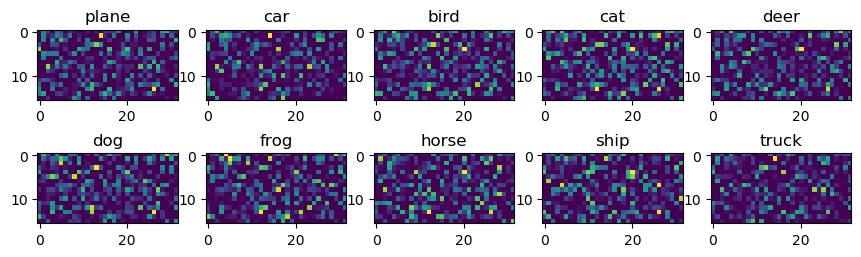

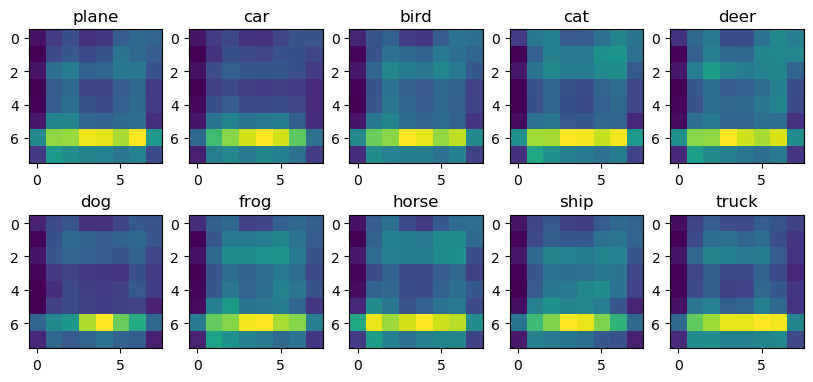

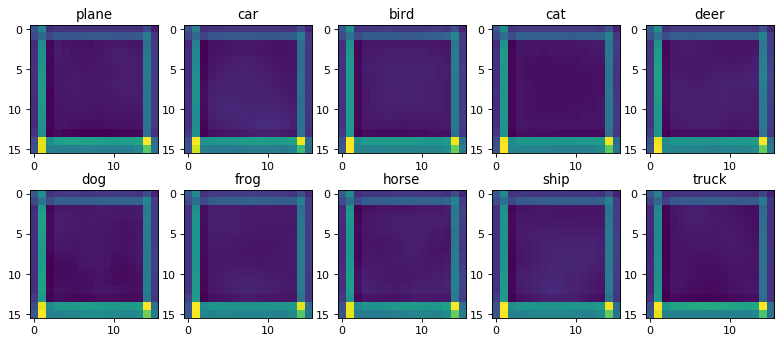

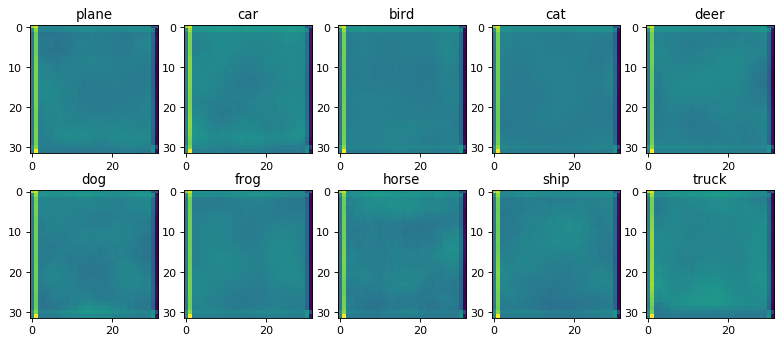

In [5]:
# draw plots of only WHITE NOISE (3rd column in above cell)
figure(num=None, figsize=(10.5, 3), dpi=100, facecolor='w', edgecolor='k')
for i in range(num_cls):
    plt.subplot(2, 5, i+1)
    plt.title(f'{classes[i]}')
    plt.imshow(fc_act_noise[i].numpy().reshape(16, 32))
plt.show()

figure(num=None, figsize=(10, 4.5), dpi=100, facecolor='w', edgecolor='k')
for i in range(num_cls):
    plt.subplot(2, 5, i+1)
    plt.title(f'{classes[i]}')
    plt.imshow(conv3_act_noise[i].mean(0).numpy())
plt.show()

figure(num=None, figsize=(12, 5), dpi=80, facecolor='w', edgecolor='k')
for i in range(num_cls):
    plt.subplot(2, 5, i+1)
    plt.title(f'{classes[i]}')
    plt.imshow(conv2_act_noise[i].mean(0).numpy())
plt.show()

figure(num=None, figsize=(12, 5), dpi=80, facecolor='w', edgecolor='k')
for i in range(num_cls):
    plt.subplot(2, 5, i+1)
    plt.title(f'{classes[i]}')
    plt.imshow(conv1_act_noise[i].mean(0).numpy())
plt.show()

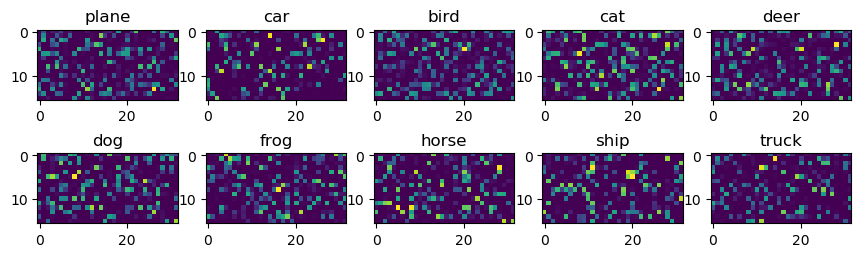

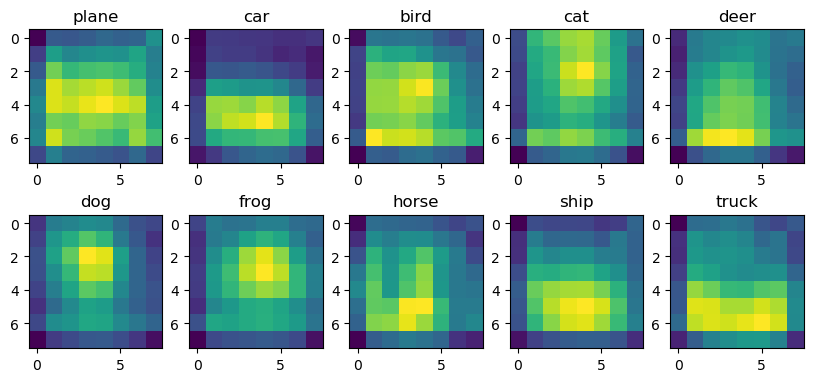

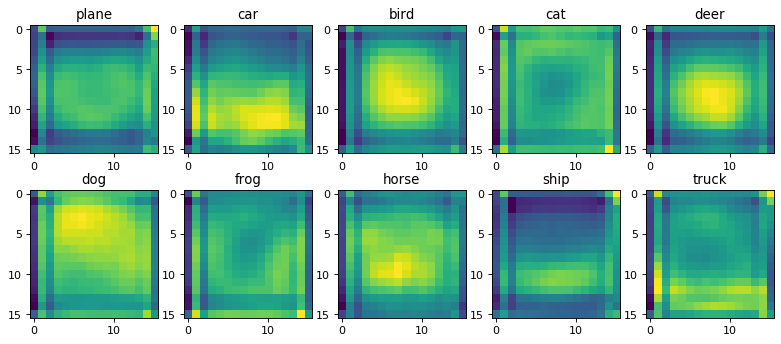

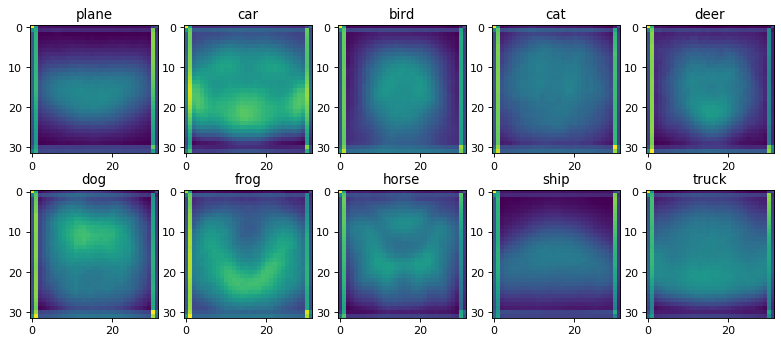

In [28]:
# draw plots of only WHITE NOISE (1st column in above cell)
figure(num=None, figsize=(10.5, 3), dpi=100, facecolor='w', edgecolor='k')
for i in range(num_cls):
    plt.subplot(2, 5, i+1)
    plt.title(f'{classes[i]}')
    plt.imshow(fc_act_gt[i].numpy().reshape(16, 32))
plt.show()

figure(num=None, figsize=(10, 4.5), dpi=100, facecolor='w', edgecolor='k')
for i in range(num_cls):
    plt.subplot(2, 5, i+1)
    plt.title(f'{classes[i]}')
    plt.imshow(conv3_act_gt[i].mean(0).numpy())
plt.show()

figure(num=None, figsize=(12, 5), dpi=80, facecolor='w', edgecolor='k')
for i in range(num_cls):
    plt.subplot(2, 5, i+1)
    plt.title(f'{classes[i]}')
    plt.imshow(conv2_act_gt[i].mean(0).numpy())
plt.show()

figure(num=None, figsize=(12, 5), dpi=80, facecolor='w', edgecolor='k')
for i in range(num_cls):
    plt.subplot(2, 5, i+1)
    plt.title(f'{classes[i]}')
    plt.imshow(conv1_act_gt[i].mean(0).numpy())
plt.show()

In [ ]:
# Adding white noise conv3 activation to real image model activation
alpha = 1
noise_act = conv3_act_noise[2]
if cuda:
    noise_act = noise_act.cuda()
with torch.no_grad():
    with tqdm(len(train_loader), file=sys.stdout) as pbar:
        for batch_idx, (data, target) in enumerate(train_loader):
            if cuda:
                data, target = data.cuda(), target.cuda()
            out, fc_out, conv3_out, conv2_out, conv1_out = model(data)
            pred = out.max(1)[1]
#             import pdb; pdb.set_trace()
            tmp_in = (1-alpha) * noise_act[None, ...].repeat(conv3_out.shape[0], 1, 1, 1) + alpha * conv3_out
            tmp_in = model.pool3(tmp_in)
            new_out = model.fc_layer2(model.fc_layer1(tmp_in.view(tmp_in.size(0), -1)))
            new_pred = new_out.max(1)[1]
            print(pred, '\r', new_pred)
            plt.hist(pred.cpu().numpy(), bins=10)
            plt.hist(new_pred.cpu().numpy(), bins=10, alpha=0.5)
            plt.show()
            import pdb; pdb.set_trace()

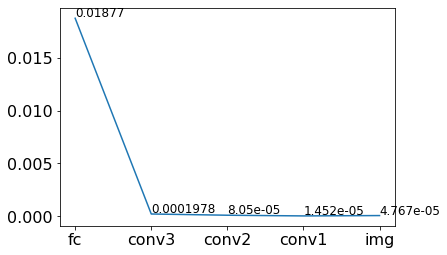

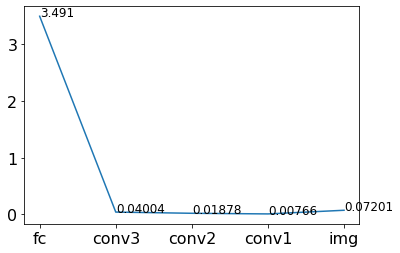

In [247]:
# plot activation pattens' distance across layers
ctr = 0
dist = {}
dist_data = {}
for key in ['fc', 'conv3', 'conv2', 'conv1', 'img']:
    dist[key] = 0
    dist_data[key] = 0
    
for i in range(num_cls -1 ):
    for j in range(i + 1, num_cls):
        dist['fc'] += torch.norm(fc_act_noise[i] - fc_act_noise[j], 2) \
        / torch.tensor(fc_act_noise[i].flatten().size()).float()
        dist['conv3'] += torch.norm(conv3_act_noise[i] - conv3_act_noise[j], 2) \
        / torch.tensor(conv3_act_noise[i].flatten().size()).float()
        dist['conv2'] += torch.norm(conv2_act_noise[i] - conv2_act_noise[j], 2) \
        / torch.tensor(conv2_act_noise[i].flatten().size()).float()
        dist['conv1'] += torch.norm(conv1_act_noise[i] - conv1_act_noise[j], 2) \
        / torch.tensor(conv1_act_noise[i].flatten().size()).float()
        dist['img'] += torch.norm(noise[i] - noise[j], 2) \
        / torch.tensor(noise[i].flatten().size()).float()
        
        dist_data['fc'] += torch.norm(fc_act_gt[i] - fc_act_gt[j], 2) \
        / torch.tensor(fc_act_gt[i].flatten().size()).float()
        dist_data['conv3'] += torch.norm(conv3_act_gt[i] - conv3_act_gt[j], 2) \
        / torch.tensor(conv3_act_gt[i].flatten().size()).float()
        dist_data['conv2'] += torch.norm(conv2_act_gt[i] - conv2_act_gt[j], 2) \
        / torch.tensor(conv2_act_gt[i].flatten().size()).float()
        dist_data['conv1'] += torch.norm(conv1_act_gt[i] - conv1_act_gt[j], 2) \
        / torch.tensor(conv1_act_gt[i].flatten().size()).float()
        dist_data['img'] += torch.norm(train_data_img[i] - train_data_img[j], 2) \
        / torch.tensor(train_data_img[i].flatten().size()).float()
        
        ctr += 1

for key in dist.keys():
    dist[key] = dist[key]/ctr

dist

x = [key for key in dist.keys()]
y1 = [dist[key].numpy() for key in dist.keys()]

# plt.title('L2 distance (per pixel/neuron) of activations across classes at differrent layers: noise')
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)

plt.plot(x, y1)
for a,b in zip(x, y1): 
    pyplot.text(a, b + 1.5e-4, '%s' % float('%.4g' % b), size='large')
plt.show()

y2 = [dist_data[key].numpy() for key in dist_data.keys()]
# plt.title('L2 distance (per pixel/neuron) of activations across classes at differrent layers: CIFAR10 training data')
plt.plot(x, y2)
for a,b in zip(x, y2): 
    pyplot.text(a, b + 3e-4, '%s' % float('%.4g' % b), size='large')
plt.show()

In [7]:
# plot misclassification vs alpha for fc/conv321
def process_perturb(x, class_id):
    perturb = cv2.resize(x[class_id].mean(0).numpy(), (p, p))
    perturb = (perturb - perturb.min())/ (perturb.max() - perturb.min())
    perturb = torch.from_numpy(np.repeat(perturb[None, ...], 3, 0)).float()
    return perturb

alphas = list(np.arange(1.0,-0.1,-0.1))
alphas = [round(number, 1) for number in alphas]
layers = ['conv3', 'conv2', 'conv1', 'img']
mistake = {}
for i in range(num_cls):
    mistake[i] = {}
    for key in layers:
        mistake[i][key] = {}
        for alpha in alphas:
            mistake[i][key][alpha] = 0

with torch.no_grad():
    for class_id in range(num_cls):
        print('Adding activation from class: ', class_id, classes[class_id])
        for alpha in alphas:
            print('alpha: ', alpha)
            for batch_idx, (data, target) in enumerate(train_loader):
                if cuda:
                    data, target = data.cuda(), target.cuda()

                # conv3
                perturb = process_perturb(conv3_act_noise, class_id)
                if cuda:
                    perturb = perturb.cuda()
                perturb = perturb[None, ...].repeat(data.shape[0], 1, 1, 1)
                data_perturbed = alpha * data + (1 - alpha) * perturb
#                 import pdb; pdb.set_trace()
                pred = model(data_perturbed)[0].max(1)[1]
                # number of images that are classified as perturb class, but actually not
                mistake[class_id]['conv3'][alpha] += (target[pred==class_id]!=class_id).sum()

                # conv2
                perturb = process_perturb(conv2_act_noise, class_id)
                if cuda:
                    perturb = perturb.cuda()
                perturb = perturb[None, ...].repeat(data.shape[0], 1, 1, 1)
                data_perturbed = alpha * data + (1 - alpha) * perturb
                pred = model(data_perturbed)[0].max(1)[1]
                # number of images that are classified as perturb class, but actually not
                mistake[class_id]['conv2'][alpha] += (target[pred==class_id]!=class_id).sum()

                # conv1
                perturb = process_perturb(conv1_act_noise, class_id)
                if cuda:
                    perturb = perturb.cuda()
                perturb = perturb[None, ...].repeat(data.shape[0], 1, 1, 1)
                data_perturbed = alpha * data + (1 - alpha) * perturb
                pred = model(data_perturbed)[0].max(1)[1]
                # number of images that are classified as perturb class, but actually not
                mistake[class_id]['conv1'][alpha] += (target[pred==class_id]!=class_id).sum()
                
                # image
                perturb = noise[class_id][None, ...].repeat(data.shape[0], 1, 1, 1)
                if cuda:
                    perturb = perturb.cuda()
                data_perturbed = alpha * data + (1 - alpha) * perturb
                pred = model(data_perturbed)[0].max(1)[1]
                # number of images that are classified as perturb class, but actually not
                mistake[class_id]['img'][alpha] += (target[pred==class_id]!=class_id).sum()

with open('cache/mistake.pkl', 'wb') as f:
    pickle.dump(mistake, f)

Adding activation from class:  0 plane
alpha:  1.0


NameError: name 'conv3_act_noise' is not defined

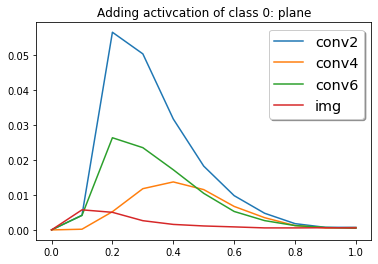

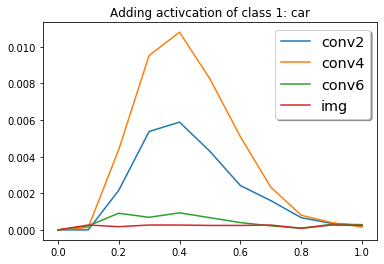

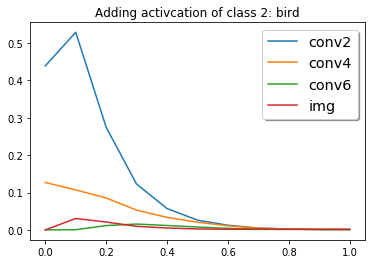

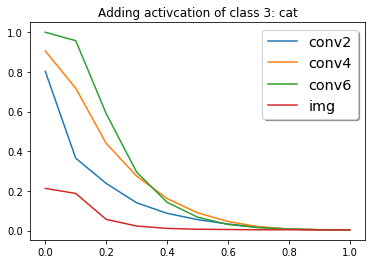

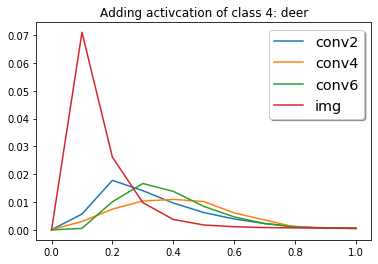

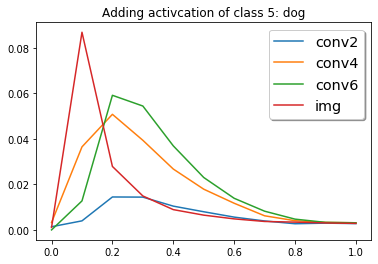

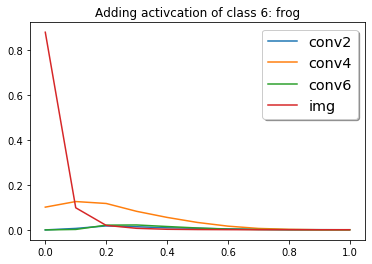

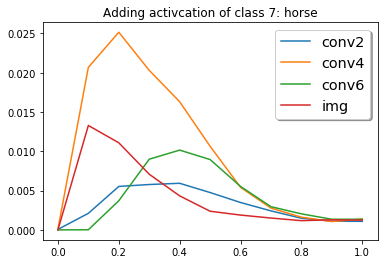

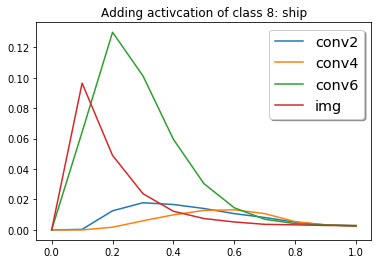

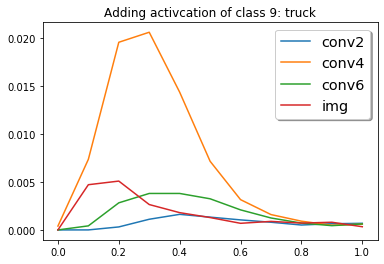

In [7]:
with open('cache/mistake.pkl', 'rb') as f:
    mistake = pickle.load(f)

alphas = list(np.arange(1.0,-0.1,-0.1))
alphas = [round(number, 1) for number in alphas]
for class_id in range(num_cls):
    m1 = [mistake[class_id]['conv1'][alpha].float()/45000 for alpha in alphas]
    m2 = [mistake[class_id]['conv2'][alpha].float()/45000 for alpha in alphas]
    m3 = [mistake[class_id]['conv3'][alpha].float()/45000 for alpha in alphas]
    m4 = [mistake[class_id]['img'][alpha].float()/45000 for alpha in alphas]
    fig, ax = plt.subplots()
    plt.title('Adding activcation of class {}: {}'.format(class_id, classes[class_id]))
    ax.plot(alphas, m1, label='conv2')
    ax.plot(alphas, m2, label='conv4')
    ax.plot(alphas, m3, label='conv6')
    ax.plot(alphas, m4, label='img')
    legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')
    plt.show()
    fig.savefig('cache/img/mis_alpha_class{}.png'.format(class_id))

Original pred: tensor([4, 8, 1, 0, 5, 8, 5, 8, 1, 9, 4, 7, 3, 5, 6, 5, 6, 7, 3, 6, 5, 8, 2, 8,
        8, 1, 1, 0, 6, 9, 4, 6, 4, 4, 3, 5, 0, 6, 8, 8, 1, 7, 6, 9, 9, 3, 6, 4,
        5, 4, 1, 4, 7, 3, 2, 1, 0, 5, 0, 1, 9, 3, 8, 7, 7, 9, 8, 2, 8, 5, 1, 8,
        8, 1, 8, 4, 0, 0, 8, 4, 8, 0, 0, 4, 4, 5, 7, 0, 5, 0, 8, 0, 4, 6, 7, 2,
        9, 0, 8, 3, 7, 9, 9, 8, 9, 0, 9, 7, 4, 8, 6, 7, 6, 4, 8, 0, 1, 2, 9, 9,
        7, 4, 1, 7, 0, 5, 1, 4, 4, 9, 1, 2, 3, 8, 7, 3, 6, 7, 4, 0, 5, 6, 6, 3,
        6, 1, 2, 4, 3, 0, 5, 7, 6, 4, 1, 5, 5, 5, 0, 8, 7, 0, 7, 4, 4, 2, 6, 1,
        2, 0, 0, 8, 9, 9, 9, 0, 5, 0, 2, 1, 8, 0, 4, 2, 5, 5, 8, 9, 4, 2, 4, 5,
        4, 9, 8, 9, 4, 3, 9, 4, 3, 0, 8, 7, 4, 2, 8, 8, 9, 0, 1, 5, 2, 8, 0, 4,
        9, 1, 3, 4, 5, 1, 8, 4, 9, 9, 4, 4, 3, 2, 4, 9, 1, 3, 6, 2, 4, 6, 0, 4,
        7, 1, 2, 7, 1, 5, 9, 5, 0, 9, 6, 7, 3, 7, 8, 2], device='cuda:0')
Perturbed pred: tensor([6, 8, 1, 6, 5, 8, 6, 6, 6, 1, 5, 6, 3, 6, 6, 5, 6, 3, 6, 6, 3, 6, 5, 7,
        8, 1, 6

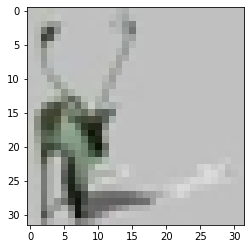

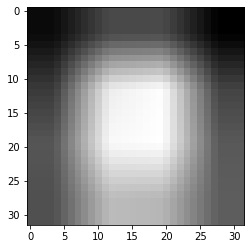

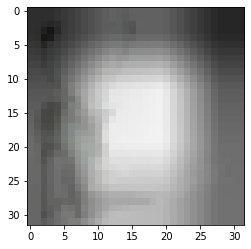

> <ipython-input-13-a76cd7c5aebf>(9)<module>()->None
-> for batch_idx, (data, target) in enumerate(train_loader):
(Pdb) plt.hist(pred, normed=True, bins=10)


/home/ali/anaconda3/envs/mehdi/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.


*** TypeError: can't convert CUDA tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.
(Pdb) plt.hist(pred.cpu().numpy(), normed=True, bins=10)
(array([0.13020833, 0.10416667, 0.078125  , 0.07378472, 0.16493056,
       0.10850694, 0.08680556, 0.09982639, 0.14322917, 0.12152778]), array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]), <a list of 10 Patch objects>)
(Pdb) plt.show()


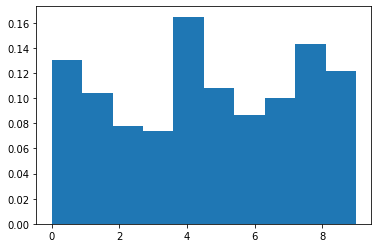

(Pdb) plt.hist(pred_perturbed.cpu().numpy(), normed=True, bins=10)
(array([0.03038194, 0.06510417, 0.        , 0.12586806, 0.04774306,
       0.1953125 , 0.46440972, 0.06510417, 0.09548611, 0.02170139]), array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]), <a list of 10 Patch objects>)
(Pdb) plt.show()


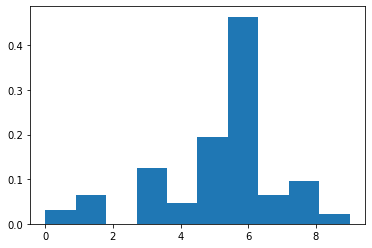

(Pdb) q


BdbQuit: 

In [13]:
# change input data with upsampled conv activation 
# (check misclassification change from original img to after adding activation)
perturb = cv2.resize(conv_act_gt[2].cpu().numpy(), (p, p))
perturb = (perturb - perturb.min())/ (perturb.max() - perturb.min())
perturb = torch.from_numpy(np.repeat(perturb[None, ...], 3, 0)).float()
pert_wt = 0.8

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda:
            data, target, perturb = data.cuda(), target.cuda(), perturb.cuda()
        pred = model(data)[0].max(1)[1]
        perturb = perturb[None, ...].repeat(data.shape[0], 1, 1, 1)
        data_perturbed = (1 - pert_wt) * data + pert_wt * perturb
#         data_perturbed = data * perturb
        pred_perturbed = model(data_perturbed)[0].max(1)[1]
        
        print('Original pred: {}'.format(pred))
        print('Perturbed pred: {}'.format(pred_perturbed))
        plt.imshow(data[0].permute(1,2,0).cpu().numpy())
        plt.show()
        plt.imshow(perturb[0].permute(1,2,0).cpu().numpy())
        plt.show()
        plt.imshow(data_perturbed[0].permute(1,2,0).cpu().numpy())
        plt.show()
        import pdb; pdb.set_trace()
        

In [9]:
# get white-noise avg based on confidence
batch_size = 250
all_size = 100000
iters = 1 #100
stats = {} # recording the bias

p = 32 # input image shape: p*p

for i in range(num_cls):
    stats[i] = 0

avgs = torch.zeros(iters, num_cls, 3, p, p)
weighted_avgs = torch.zeros(iters, num_cls, 3, p, p)

for kk in range(iters):
    print(kk)
    all_preds = []
    all_confs = []
    all_idx = torch.ones(all_size, dtype = torch.uint8)
    z = torch.rand(all_size, 3, p, p)
#     z[z<.5] = 0
#     z[z>=.5] = 1
    with tqdm(total=all_size//batch_size, file=sys.stdout) as pbar:
        for k in range(0,all_size, batch_size):
            with torch.no_grad():
                out, fc_out = model(z[k:k+batch_size].cuda())
                y_pred = F.softmax(out, 1)
            # erasing the low confident ones!
            y_pred[y_pred < 0.3]= 0

            indices = torch.ones(y_pred.size(0), dtype = torch.uint8)
            indices[torch.mean(y_pred, dim =1)==0] = 0

            all_idx[k:k+batch_size] = indices
            conf, pred = y_pred[indices==1].data.max(1)#[1]
            # only using the max conf
            # TODO: using all the predictions with corresponding weights
            all_preds.append(pred)
            all_confs.append(conf)

            pbar.update(1)

    preds = torch.cat(all_preds)
    confs = torch.cat(all_confs)
    z = z[all_idx]

#     
    for i in range(num_cls):
        stats[i] += torch.sum(preds==i)
        a1 = torch.mean(z[preds==i] , dim=0)
        avgs[kk, i] = a1
        a2 = torch.mm(confs[preds==i].cpu().unsqueeze(0), 
                 z[preds==i].view(z[preds==i].shape[0],-1))/confs[preds==i].cpu().sum()
        weighted_avgs[kk, i] = a2.reshape(3, p, p)


0
  0%|          | 0/400 [00:00<?, ?it/s]> <ipython-input-9-9fb44afd49b1>(28)<module>()
-> y_pred = F.softmax(model(z[k:k+batch_size].cuda()), 1)
(Pdb) out.shape
torch.Size([250, 10])
(Pdb) mid_out.shape
torch.Size([250, 512])
(Pdb) q



BdbQuit: 

In [7]:
for i in range(num_cls):
    print('{}, {}: {}'.format(i, classes[i], stats[i]))

0, plane: 3871
1, car: 556
2, bird: 9745
3, cat: 33671
4, deer: 24000
5, dog: 2897
6, frog: 18644
7, horse: 2925
8, ship: 1297
9, truck: 2113


In [ ]:
z = torch.rand(1000000, 3, p, p)
grand_mean = torch.mean(z, dim=0)
print(grand_mean.shape)

## classification using neareast neighbor of averagged training data image

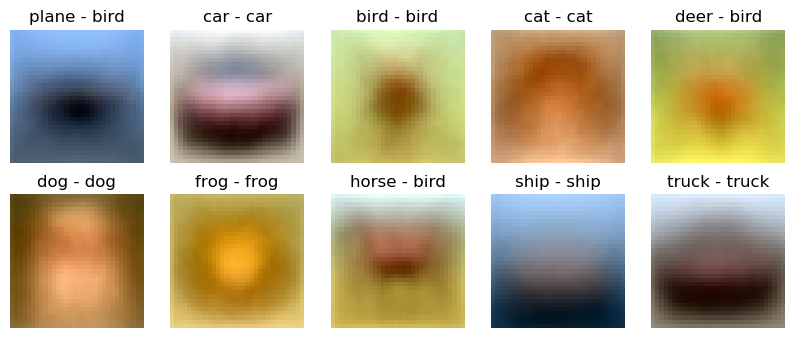

In [195]:
###### plot data mean #####
stats = {}
for i in range(num_cls):
    stats[i] = 0
    
# all training images
avgs = torch.zeros(len(train_loader), num_cls, 3, p, p)
for batch_idx, (data, target) in enumerate(train_loader):
    for i in range(num_cls):
        subdata = data[target == i]
#         avgs[batch_idx, i] = data[target == i].mean(0)
        avgs[batch_idx, i] = torch.sqrt((subdata**2).mean(0))
        stats[i] += subdata.shape[0]
# # 1 batch
# avgs = torch.zeros(1, num_cls, 3, p, p)
# data, target = next(iter(train_loader))
# for i in range(num_cls):
#     subdata = data[target == i]
#     avgs[0, i] = torch.sqrt((subdata**2).mean(0))
#     stats[i] += subdata.shape[0]

data_avg = torch.mean(avgs, dim=0)
figure(num=None, figsize=(10, 4), dpi=100, facecolor='w', edgecolor='k')
for i in range(num_cls):
    a = data_avg[i]
    a = (a - a.min()) / (a.max() - a.min())
    pred = model(a[None,...].cuda())[0].max(1)[1]
    plt.subplot(2, 5, i+1)
    plt.axis('off')
#     plt.title(f'gt: {classes[i]}  -  pred: {classes[pred.cpu().numpy()[0]]}') # -  size-gt: {stats[i]}')
    plt.title(f'{classes[i]} - {classes[pred.cpu().numpy()[0]]}')
    plt.imshow(a.permute(1,2,0), cmap='jet')
plt.show()

In [159]:
def plot_confusion_matrix( y_pred, y_true, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
  
    import sklearn
    from sklearn import metrics
#     cf = sklearn.metrics.confusion_matrix(pred.numpy(), gt.numpy())  
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
  
    # Compute confusion matrix
    cm = sklearn.metrics.confusion_matrix(y_pred, y_true)
    # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] )
#         print("Normalized confusion matrix")
    else:
        pass
#         print('Confusion matrix, without normalization')
#     print(cm)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
#     ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]+1)-0.5,
           yticks=np.arange(cm.shape[0]+1)-0.5,
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Predicted label',
           xlabel='True label')
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
np.set_printoptions(precision=2)
# # Plot non-normalized confusion matrix
# plot_confusion_matrix(y_test, y_pred, classes=class_names,
#                       title='Confusion matrix, without normalization')
# # Plot normalized confusion matrix
# plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
#                       title='Normalized confusion matrix')
# plt.show()

data vector size:  torch.Size([10, 3072])
Accuracy:  0.2575


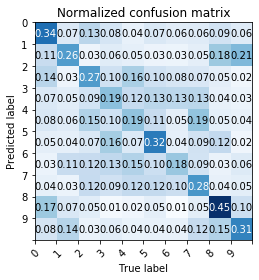

In [160]:
# Get classification accuracy and confusion matrix
##### sklearn NN #####
data_avg_vec = data_avg.reshape(num_cls, -1)
print('data vector size: ', data_avg_vec.shape)

from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(data_avg_vec)

pred = []
gt = []
for batch_idx, (data, target) in enumerate(test_loader):
    _, indices = nbrs.kneighbors(data.numpy().reshape(len(data), -1))
    pred.append(torch.from_numpy(indices.flatten()))
    gt.append(target)

pred = torch.cat(pred)
gt = torch.cat(gt)
# import pdb; pdb.set_trace()
acc = (pred==gt).sum().type(dtype=torch.float64) / len(gt)

print('Accuracy: ', acc.numpy())
plot_confusion_matrix(pred.numpy(), gt.numpy(), classes=list(range(10)), normalize=True,  title='Normalized confusion matrix using real data average (NN)')

data vector size:  torch.Size([10, 3072])
Accuracy:  0.2869


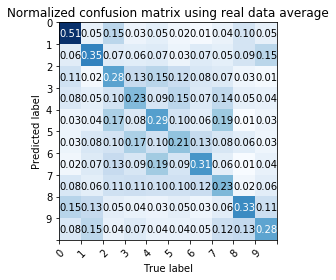

In [165]:
##### Dot product NN #####
data_avg_vec = data_avg.reshape(num_cls, -1)
print('data vector size: ', data_avg_vec.shape)

pred = []
gt = []
templates = data_avg_vec.permute(1, 0)
templates = templates / torch.norm(templates, p=2, dim=0)
for batch_idx, (data, target) in enumerate(test_loader):
    x = data.view(data.shape[0], -1)
    x = x / torch.cat([torch.norm(x, p=2, dim=1).view(-1,1)] * x.shape[1], 1)
    pred.append(torch.mm(x, templates).max(1)[1])
    gt.append(target)
pred = torch.cat(pred)
gt = torch.cat(gt)

acc = (pred==gt).sum().type(dtype=torch.float64) / len(gt)
print('Accuracy: ', acc.numpy())
plot_confusion_matrix(pred.numpy(), gt.numpy(), classes=list(range(10)), normalize=True,  title='Normalized confusion matrix using real data average')

## classification using neareast neighbor of averagged white noise

In [188]:
# prepare noise average vector (loading from multiple files)
file_num = 10
noise_avg = {}
for i in range(num_cls):
    noise_avg[i] = []
for i in range(1, file_num+1):
    with open('cache/noise_acts{}.pkl'.format(i), 'rb') as f:
        noise_img = pickle.load(f)['img']
        for k in range(num_cls):
            noise_avg[k].append(noise_img[k][None, ...])

noise_avg_vec = []
for i in range(num_cls):
#     a = torch.cat(noise_avg[i]).mean(0)
#     a = (a - a.min())/ (a.max() - a.min())
#     noise_avg_vec.append(a.numpy().reshape(1,-1))
    noise_avg_vec.append(torch.cat(noise_avg[i]).mean(0).numpy().reshape(1,-1))
noise_avg_vec = np.concatenate(noise_avg_vec)
print('noise vector size: ', noise_avg_vec.shape)

noise vector size:  (10, 3072)


In [249]:
##### Plot noise mean #####

figure(num=None, figsize=(10, 4), dpi=100, facecolor='w', edgecolor='k')
for i in range(num_cls):
    a = torch.cat(noise_avg[i]).mean(0)
    a = (a - a.min())/ (a.max() - a.min())
    pred = model(a[None, ...].cuda())[0].max(1)[1]
    plt.subplot(2, 5, i+1)
#     plt.title(f'gt: {classes[i]} - pred: {classes[pred]}')#' -  size-gt: {stats[i]}')
#     plt.title(f'{i} - {classes[i]}')
    plt.title(f'{classes[i]} - {classes[pred]}')
    plt.axis('off')
    plt.imshow(a.permute(1,2,0).numpy(), cmap = 'jet')
plt.show()
  

TypeError: cat(): argument 'tensors' (position 1) must be tuple of Tensors, not Tensor

<Figure size 1000x400 with 0 Axes>

Accuracy:  0.2183


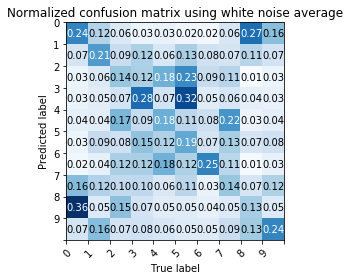

In [189]:
##### sklearn NN #####
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(noise_avg_vec)

pred = []
gt = []
for batch_idx, (data, target) in enumerate(test_loader):
    _, indices = nbrs.kneighbors(data.numpy().reshape(len(data), -1))
    pred.append(torch.from_numpy(indices.flatten()))
    gt.append(target)

pred = torch.cat(pred)
gt = torch.cat(gt)
# import pdb; pdb.set_trace()
acc = (pred==gt).sum().type(dtype=torch.float64) / len(gt)

print('Accuracy: ', acc.numpy())
plot_confusion_matrix(pred.numpy(), gt.numpy(), classes=list(range(10)), normalize=True,  title='Normalized confusion matrix using white noise average')

Accuracy:  0.2371


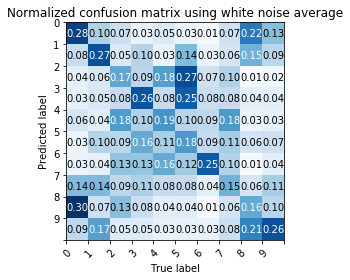

In [190]:
##### Dot product NN #####

pred = []
gt = []
templates = torch.from_numpy(noise_avg_vec).permute(1, 0)
templates = templates / torch.norm(templates, p=2, dim=0)

# templates = (templates -  templates.min()) / (templates.max() -  templates.min())
for batch_idx, (data, target) in enumerate(test_loader):
#     data = (data -  data.min()) / (data.max() -  data.min())
    x = data.view(data.shape[0], -1)
    x = x / torch.cat([torch.norm(x, p=2, dim=1).view(-1,1)] * x.shape[1], 1)
    pred.append(torch.mm(x, templates).max(1)[1])
    gt.append(target)
pred = torch.cat(pred)
gt = torch.cat(gt)

acc = (pred==gt).sum().type(dtype=torch.float64) / len(gt)
print('Accuracy: ', acc.numpy())
plot_confusion_matrix(pred.numpy(), gt.numpy(), classes=list(range(10)), normalize=True,  title='Normalized confusion matrix using white noise average')



## Receptive Field helper

In [57]:
convnet =   [[3,1,1],[3,1,1],[2,2,0],[3,1,1],[3,1,1],[2,2,0],[3,1,1],[3,1,1],[2,2,0]]
layer_names = ['conv1','conv2','pool1','conv3','conv4','pool2','conv5','conv6', 'pool3']
imsize = 32

def outFromIn(conv, layerIn):
    n_in = layerIn[0]
    j_in = layerIn[1]
    r_in = layerIn[2]
    start_in = layerIn[3]
    
    k = conv[0]
    s = conv[1]
    p = conv[2]
    
    n_out = math.floor((n_in - k + 2*p)/s) + 1
    actualP = (n_out-1)*s - n_in + k
    pR = math.ceil(actualP/2)
    pL = math.floor(actualP/2)
    
    j_out = j_in * s
    r_out = r_in + (k - 1)*j_in
    start_out = start_in + ((k-1)/2 - pL)*j_in
    return n_out, j_out, r_out, start_out
  
def printLayer(layer, layer_name):
    print(layer_name + ":")
    print("\t n features: %s \n \t jump: %s \n \t receptive size: %s \t start: %s " % (
        layer[0], layer[1], layer[2], layer[3]))
    
layerInfos = []
#first layer is the data layer (image) with n_0 = image size; j_0 = 1; r_0 = 1; and start_0 = 0.5
print ("-------Net summary------")
currentLayer = [imsize, 1, 1, 0.5]
printLayer(currentLayer, "input image")
for i in range(len(convnet)):
    currentLayer = outFromIn(convnet[i], currentLayer)
    layerInfos.append(currentLayer)
    printLayer(currentLayer, layer_names[i])
print ("------------------------")
# import pdb; pdb.set_trace()
# layer_name = raw_input ("Layer name where the feature in: ")
# layer_idx = layer_names.index(layer_name)
# idx_x = int(raw_input ("index of the feature in x dimension (from 0)"))
# idx_y = int(raw_input ("index of the feature in y dimension (from 0)"))

# n = layerInfos[layer_idx][0]
# j = layerInfos[layer_idx][1]
# r = layerInfos[layer_idx][2]
# start = layerInfos[layer_idx][3]
# assert(idx_x < n)
# assert(idx_y < n)

# print ("receptive field: (%s, %s)" % (r, r))
# print ("center: (%s, %s)" % (start+idx_x*j, start+idx_y*j))

-------Net summary------
input image:
	 n features: 32 
 	 jump: 1 
 	 receptive size: 1 	 start: 0.5 
conv1:
	 n features: 32 
 	 jump: 1 
 	 receptive size: 3 	 start: 0.5 
conv2:
	 n features: 32 
 	 jump: 1 
 	 receptive size: 5 	 start: 0.5 
pool1:
	 n features: 16 
 	 jump: 2 
 	 receptive size: 6 	 start: 1.0 
conv3:
	 n features: 16 
 	 jump: 2 
 	 receptive size: 10 	 start: 1.0 
conv4:
	 n features: 16 
 	 jump: 2 
 	 receptive size: 14 	 start: 1.0 
pool2:
	 n features: 8 
 	 jump: 4 
 	 receptive size: 16 	 start: 2.0 
conv5:
	 n features: 8 
 	 jump: 4 
 	 receptive size: 24 	 start: 2.0 
conv6:
	 n features: 8 
 	 jump: 4 
 	 receptive size: 32 	 start: 2.0 
pool3:
	 n features: 4 
 	 jump: 8 
 	 receptive size: 36 	 start: 4.0 
------------------------


In [17]:
def padded_rf(img, key, i, j, p=28):
    rf_info = {'conv0':[0.5, 1, 3, 32, 32], 'conv1':[0.5, 1, 5, 32, 64], 
           'conv2':[1.0, 2, 14, 16, 128], 'conv3':[2.0, 4, 32, 8, 256]}
    p_rf = rf_info[key][2]
    p_feat = rf_info[key][3]
    center_i = rf_info[key][0] + i * rf_info[key][1]
    center_j = rf_info[key][0] + j * rf_info[key][1]
    left = int(center_i - p_rf / 2)
    right = int(center_i + p_rf / 2)
    up = int(center_j - p_rf / 2)
    bottom = int(center_j + p_rf / 2)

    cur_rf = img[:, max(up, 0): min(bottom, p), max(left, 0): min(right, p)]
    if left < 0: # pad left
        tmp = torch.zeros(3, cur_rf.shape[1], cur_rf.shape[2] - left)
        tmp[:, :, -left:] = cur_rf
        cur_rf = tmp
    if up < 0: # pad up
        tmp = torch.zeros(3, cur_rf.shape[1] - up, cur_rf.shape[2])
        tmp[:, -up:, :] = cur_rf
        cur_rf = tmp
    if right > p: # pad right
        tmp = torch.zeros(3, cur_rf.shape[1], cur_rf.shape[2] + (right - p))
        tmp[:, :, : -(right-p)] = cur_rf
        cur_rf = tmp
    if bottom > p: # pad bottom
        tmp = torch.zeros(3, cur_rf.shape[1] + (bottom - p), cur_rf.shape[2])
        tmp[:, : -(bottom-p), :] = cur_rf
        cur_rf = tmp
    return cur_rf

## Receptive Field - Noise

In [21]:
# generate random pattern, recording the upper-left neuron responses at each channel
iter_ = 1000
all_size = 1000

# checked_neuron position
pos_x = 0
pos_y = 0

model.eval()
act_conv0 = []
act_conv1 = []
act_conv2 = []
act_conv3 = []
noise = []
with tqdm(total=iter_, file=sys.stdout) as pbar:
    for i in range(iter_):
        z = torch.rand(all_size, 3, p, p)
        if cuda:
            z = z.cuda()
        with torch.no_grad():
            _, _, x3, x2, x1, x0 = model(z)
#             _, _, x3, x2, x1 = model_pruned(z)
#         import pdb; pdb.set_trace()
        act_conv3.append(x3[:, :, pos_x, pos_y].cpu())
        act_conv2.append(x2[:, :, pos_x, pos_y].cpu())
        act_conv1.append(x1[:, :, pos_x, pos_y].cpu())
        act_conv0.append(x0[:, :, pos_x, pos_y].cpu())
        noise.append(z.cpu())

        pbar.update(1)

noise = torch.cat(noise)
act_conv0 = torch.cat(act_conv0)
act_conv1 = torch.cat(act_conv1)
act_conv2 = torch.cat(act_conv2)
act_conv3 = torch.cat(act_conv3)

print(noise.shape)
print(act_conv0.shape)
print(act_conv1.shape)
print(act_conv2.shape)
print(act_conv3.shape)

100%|██████████| 1000/1000 [00:49<00:00, 20.03it/s]
torch.Size([1000000, 3, 32, 32])
torch.Size([1000000, 32])
torch.Size([1000000, 64])
torch.Size([1000000, 128])
torch.Size([1000000, 256])


In [22]:
noise_num = noise.numpy().shape[0]
rf_0 = min(3, p)
rf_1 = min(5, p)
rf_2 = min(14, p)
rf_3 = min(32, p)
print(rf_0, rf_1, rf_2, rf_3)
conv0_rf = torch.zeros(act_conv0.shape[1], 3, rf_0, rf_0)
conv1_rf = torch.zeros(act_conv1.shape[1], 3, rf_1, rf_1)
conv2_rf = torch.zeros(act_conv2.shape[1], 3, rf_2, rf_2)
conv3_rf = torch.zeros(act_conv3.shape[1], 3, rf_3, rf_3)
with tqdm(total=noise_num, file=sys.stdout) as pbar:
    for i in range(noise_num):
        # conv0: weighted 3*3
        conv0_rf += padded_rf(noise[i], 'conv0', pos_x, pos_y)[None, ...].repeat(
            act_conv0.shape[1], 1, 1, 1) * act_conv0[i][..., None, None, None]
        # conv1: weighted 5*5
        conv1_rf += padded_rf(noise[i], 'conv1', pos_x, pos_y)[None, ...].repeat(
            act_conv1.shape[1], 1, 1, 1) * act_conv1[i][..., None, None, None]
        # conv2: weighted 14*14
        conv2_rf += padded_rf(noise[i], 'conv2', pos_x, pos_y)[None, ...].repeat(
            act_conv2.shape[1], 1, 1, 1) * act_conv2[i][..., None, None, None]
        # conv3: weighted 32*32
        conv3_rf += padded_rf(noise[i], 'conv3', pos_x, pos_y)[None, ...].repeat(
            act_conv3.shape[1], 1, 1, 1) * act_conv3[i][..., None, None, None]

        # save a checkpoint per 1000 iterations
        if not (i+1) % 1000:
            tmp_rf = {'processed': i+1, 'conv0_rf':conv0_rf, 'conv1_rf':conv1_rf, 
                      'conv2_rf':conv2_rf, 'conv3_rf':conv3_rf}
            with open('cache/cifar10_rf.pkl', 'wb') as f:
                pickle.dump(tmp_rf, f)
        pbar.update(1)

3 5 14 32
100%|██████████| 1000000/1000000 [04:46<00:00, 3488.78it/s]


In [23]:
with open('cache/cifar10_rf.pkl', 'rb') as f:
    rf = pickle.load(f)

print(rf['processed'])
print(rf['conv0_rf'].shape)
print(rf['conv1_rf'].shape)
print(rf['conv2_rf'].shape)
print(rf['conv3_rf'].shape)

1000000
torch.Size([32, 3, 3, 3])
torch.Size([64, 3, 5, 5])
torch.Size([128, 3, 14, 14])
torch.Size([256, 3, 32, 32])


In [15]:
# averaging receptive field over all neurons in one channel
iter_ = 50
all_size = 1000
model.eval()

# start center, jump, rf size, feature map size, channel_num
rf_info = {'conv0':[0.5, 1, 3, 32, 32], 'conv1':[0.5, 1, 5, 32, 64], 
           'conv2':[1.0, 2, 14, 16, 128], 'conv3':[2.0, 4, 32, 8, 256]}
rf_info = {'conv0':[0.5, 1, 3, 32, 32]}
rf = {}
for layer in rf_info:
    rf[layer] = []
act = {}
# key = 'conv1'
for i in range(iter_):
    print(i)
    z = torch.rand(all_size, 3, p, p)
    if cuda:
        z = z.cuda()
    with torch.no_grad():
        _, _, act['conv3'], act['conv2'], act['conv1'], act['conv0'] = model(z)
    
    for key in rf_info:
        p_rf = rf_info[key][2]
        p_feat = rf_info[key][3]
        channel_num = rf_info[key][4]
        batch_avg = []
        with tqdm(total=len(z), file=sys.stdout) as pbar:
            for im_id in range(len(z)):
                img = z[im_id].cpu()
                cur_act = act[key][im_id].cpu()
                img_avg = torch.zeros(channel_num, 3, p_rf, p_rf)
                for i in range(p_feat):
                    for j in range(p_feat):
                        center_i = rf_info[key][0] + i * rf_info[key][1]
                        center_j = rf_info[key][0] + j * rf_info[key][1]
                        left = int(center_i - p_rf / 2)
                        right = int(center_i + p_rf / 2)
                        up = int(center_j - p_rf / 2)
                        bottom = int(center_j + p_rf / 2)

                        cur_rf = img[:, max(up, 0): min(bottom, p), max(left, 0): min(right, p)]
                        if left < 0: # pad left
                            tmp = torch.zeros(3, cur_rf.shape[1], cur_rf.shape[2] - left)
                            tmp[:, :, -left:] = cur_rf
                            cur_rf = tmp
                        if up < 0: # pad up
                            tmp = torch.zeros(3, cur_rf.shape[1] - up, cur_rf.shape[2])
                            tmp[:, -up:, :] = cur_rf
                            cur_rf = tmp
                        if right > p: # pad right
                            tmp = torch.zeros(3, cur_rf.shape[1], cur_rf.shape[2] + (right - p))
                            tmp[:, :, : -(right-p)] = cur_rf
                            cur_rf = tmp
                        if bottom > p: # pad bottom
                            tmp = torch.zeros(3, cur_rf.shape[1] + (bottom - p), cur_rf.shape[2])
                            tmp[:, : -(bottom-p), :] = cur_rf
                            cur_rf = tmp

                        img_avg += cur_rf[None, ...].repeat(channel_num, 
                                                            1, 1, 1) * cur_act[:, i, j][..., None, None, None]
                img_avg  = img_avg / (p_feat ** 2)
                batch_avg.append(img_avg[None, ...])
                pbar.update(1)
        rf[key].append(torch.cat(batch_avg).mean(0)[None, ...])

for key in rf_info:
    rf[key] = torch.cat(rf[key]).mean(0)


0
100%|██████████| 1000/1000 [00:36<00:00, 27.17it/s]
1
100%|██████████| 1000/1000 [00:36<00:00, 27.29it/s]
2
100%|██████████| 1000/1000 [00:36<00:00, 27.23it/s]
3
100%|██████████| 1000/1000 [00:36<00:00, 27.20it/s]
4
100%|██████████| 1000/1000 [00:37<00:00, 26.79it/s]
5
100%|██████████| 1000/1000 [00:36<00:00, 27.13it/s]
6
100%|██████████| 1000/1000 [00:36<00:00, 27.12it/s]
7
100%|██████████| 1000/1000 [00:36<00:00, 27.05it/s]
8
100%|██████████| 1000/1000 [00:36<00:00, 27.06it/s]
9
100%|██████████| 1000/1000 [00:36<00:00, 27.10it/s]
10
100%|██████████| 1000/1000 [00:36<00:00, 27.17it/s]
11
100%|██████████| 1000/1000 [00:37<00:00, 26.82it/s]
12
100%|██████████| 1000/1000 [00:37<00:00, 26.74it/s]
13
100%|██████████| 1000/1000 [00:37<00:00, 26.84it/s]
14
100%|██████████| 1000/1000 [00:36<00:00, 27.15it/s]
15
100%|██████████| 1000/1000 [00:36<00:00, 27.13it/s]
16
100%|██████████| 1000/1000 [00:36<00:00, 27.14it/s]
17
100%|██████████| 1000/1000 [00:36<00:00, 27.22it/s]
18
100%|██████████| 

In [61]:
# helper block for checking particular neuron's rf position

rf_info = {'conv0':[0.5, 1, 3, 32, 32], 'conv1':[0.5, 1, 5, 32, 64], 
           'conv2':[1.0, 2, 14, 16, 128], 'conv3':[2.0, 4, 32, 8, 256]}
key = 'conv3'
p_rf = rf_info[key][2]
p_feat = rf_info[key][3]

for i in range(p_feat):
    for j in range(p_feat):
        center_i = rf_info[key][0] + i * rf_info[key][1]
        center_j = rf_info[key][0] + j * rf_info[key][1]
        left = int(center_i - p_rf / 2)
        right = int(center_i + p_rf / 2)
        up = int(center_j - p_rf / 2)
        bottom = int(center_j + p_rf / 2)
        
        print('({},{}): {}, {}, {}, {}'.format(i, j, left, right, up, bottom))

(0,0): -14, 18, -14, 18
(0,1): -14, 18, -10, 22
(0,2): -14, 18, -6, 26
(0,3): -14, 18, -2, 30
(0,4): -14, 18, 2, 34
(0,5): -14, 18, 6, 38
(0,6): -14, 18, 10, 42
(0,7): -14, 18, 14, 46
(1,0): -10, 22, -14, 18
(1,1): -10, 22, -10, 22
(1,2): -10, 22, -6, 26
(1,3): -10, 22, -2, 30
(1,4): -10, 22, 2, 34
(1,5): -10, 22, 6, 38
(1,6): -10, 22, 10, 42
(1,7): -10, 22, 14, 46
(2,0): -6, 26, -14, 18
(2,1): -6, 26, -10, 22
(2,2): -6, 26, -6, 26
(2,3): -6, 26, -2, 30
(2,4): -6, 26, 2, 34
(2,5): -6, 26, 6, 38
(2,6): -6, 26, 10, 42
(2,7): -6, 26, 14, 46
(3,0): -2, 30, -14, 18
(3,1): -2, 30, -10, 22
(3,2): -2, 30, -6, 26
(3,3): -2, 30, -2, 30
(3,4): -2, 30, 2, 34
(3,5): -2, 30, 6, 38
(3,6): -2, 30, 10, 42
(3,7): -2, 30, 14, 46
(4,0): 2, 34, -14, 18
(4,1): 2, 34, -10, 22
(4,2): 2, 34, -6, 26
(4,3): 2, 34, -2, 30
(4,4): 2, 34, 2, 34
(4,5): 2, 34, 6, 38
(4,6): 2, 34, 10, 42
(4,7): 2, 34, 14, 46
(5,0): 6, 38, -14, 18
(5,1): 6, 38, -10, 22
(5,2): 6, 38, -6, 26
(5,3): 6, 38, -2, 30
(5,4): 6, 38, 2, 34
(5,5):

In [16]:
rf.keys()

dict_keys(['conv0'])

In [17]:
key_ = 'conv0'
tmp = {}
tmp['{}_rf'.format(key_)] = rf[key_]
sup = '_tanh'
with open('cache/noise_{}_rf{}.pkl'.format(key_, sup), 'wb') as f:
    pickle.dump(tmp, f)

In [13]:
rf = {}
sup = '_tanh'
with open('cache/noise_conv0_rf{}.pkl'.format(sup), 'rb') as f:
    rf['conv0_rf'] = pickle.load(f)['conv0_rf']
with open('cache/noise_conv1_rf{}.pkl'.format(sup), 'rb') as f:
    rf['conv1_rf'] = pickle.load(f)['conv1_rf']
with open('cache/noise_conv2_rf{}.pkl'.format(sup), 'rb') as f:
    rf['conv2_rf'] = pickle.load(f)['conv2_rf']
with open('cache/noise_conv3_rf{}.pkl'.format(sup), 'rb') as f:
    rf['conv3_rf'] = pickle.load(f)['conv3_rf']

rf.keys()

dict_keys(['conv0_rf', 'conv1_rf', 'conv2_rf', 'conv3_rf'])

conv0 RF: shape: (3, 3, 3)


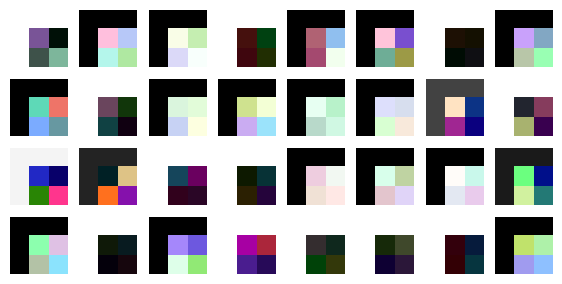

conv1 RF: shape: (5, 5, 3)


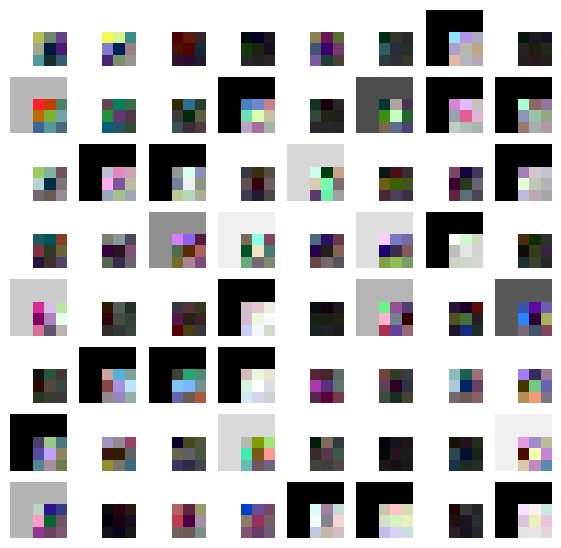

conv2 RF: shape: (14, 14, 3)


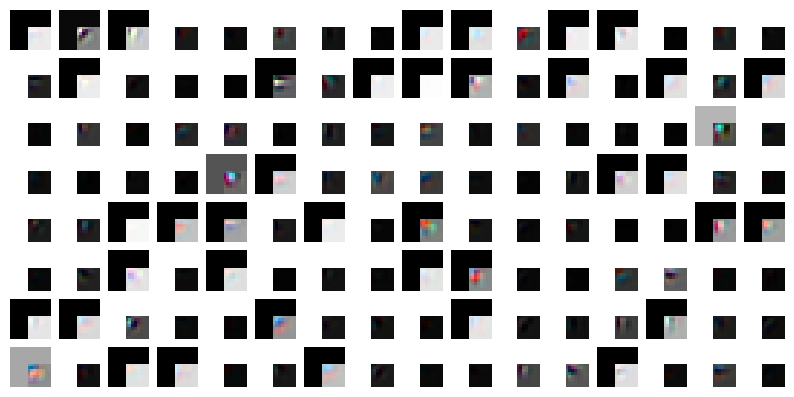

conv3 RF: shape: (32, 32, 3)


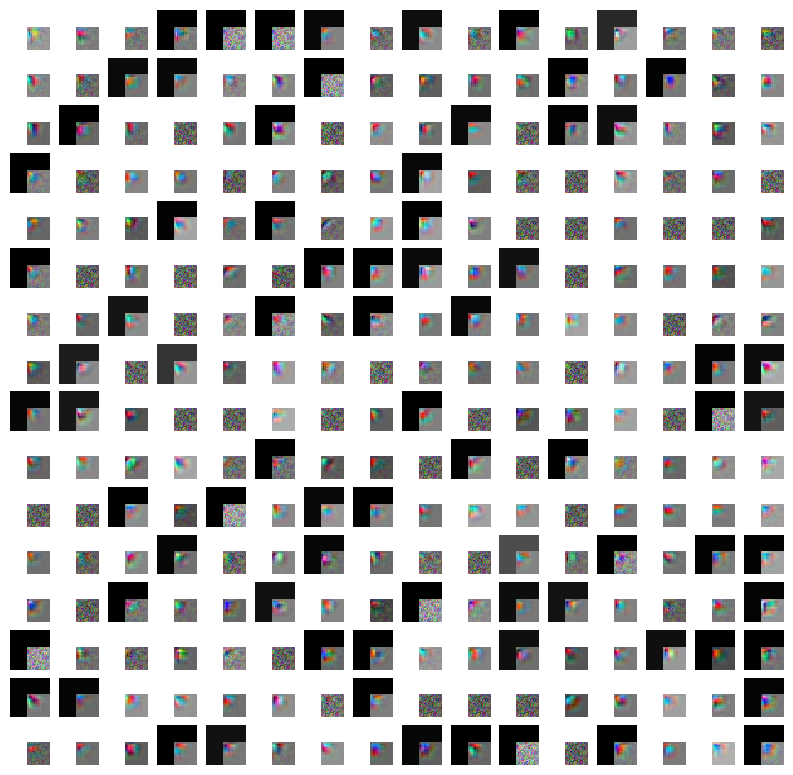

Useless neuron counts: conv1 0/64, conv2 0/128, conv3 0/256


In [24]:
# rf of conv0
print('conv0 RF: shape: {}'.format(rf['conv0_rf'][0].permute(1, 2, 0).numpy().shape))
figure(num=None, figsize=(7, 3.5), dpi=100, facecolor='w', edgecolor='k')
conv0_ctr = 0
for i in range(rf['conv0_rf'].shape[0]):
    plt.subplot(4, 8, i+1)
    plt.axis('off')
    to_show = rf['conv0_rf'][i].permute(1, 2, 0).numpy()
    if to_show.min() == 0 and to_show.max() == 0:
        conv0_ctr += 1
        plt.imshow(to_show)
    else:
        plt.imshow((to_show - to_show.min())/(to_show.max() - to_show.min()))
plt.show()

# rf of conv1
print('conv1 RF: shape: {}'.format(rf['conv1_rf'][0].permute(1, 2, 0).numpy().shape))
figure(num=None, figsize=(7, 7), dpi=100, facecolor='w', edgecolor='k')
conv1_ctr = 0
for i in range(rf['conv1_rf'].shape[0]):
    plt.subplot(8, 8, i+1)
    plt.axis('off')
    to_show = rf['conv1_rf'][i].permute(1, 2, 0).numpy()
    if to_show.min() == 0 and to_show.max() == 0:
        conv1_ctr += 1
        plt.imshow(to_show)
    else:
        plt.imshow((to_show - to_show.min())/(to_show.max() - to_show.min()))
plt.show()

# rf of conv2
print('conv2 RF: shape: {}'.format(rf['conv2_rf'][0].permute(1, 2, 0).numpy().shape))
figure(num=None, figsize=(10, 5), dpi=100, facecolor='w', edgecolor='k')
conv2_ctr = 0
for i in range(rf['conv2_rf'].shape[0]):
    plt.subplot(8, 16, i+1)
    plt.axis('off')
    to_show = rf['conv2_rf'][i].permute(1, 2, 0).numpy()
    if to_show.min() == 0 and to_show.max() == 0:
        conv2_ctr += 1
        plt.imshow(to_show)
    else:
        plt.imshow((to_show - to_show.min())/(to_show.max() - to_show.min()))
plt.show()

# rf of conv3
print('conv3 RF: shape: {}'.format(rf['conv3_rf'][0].permute(1, 2, 0).numpy().shape))
figure(num=None, figsize=(10, 10), dpi=100, facecolor='w', edgecolor='k')
conv3_ctr = 0
for i in range(rf['conv3_rf'].shape[0]):
    plt.subplot(16, 16, i+1)
    plt.axis('off')
    to_show = rf['conv3_rf'][i].permute(1, 2, 0).numpy()
    
#     plt.imshow(to_show/(rf['processed']))
    if to_show.min() == 0 and to_show.max() == 0:
        conv3_ctr += 1
        plt.imshow(to_show)
    else:
        if to_show.max() == 0:
#             import pdb; pdb.set_trace()
            to_show[to_show == 0] = sorted(set(list(to_show.flatten())))[-2] * 0.999
        if to_show.min() == 0:
            to_show[to_show == 0] = sorted(set(list(to_show.flatten())))[2] * 0.999
        to_show = (to_show - to_show.min())/(to_show.max() - to_show.min())
        plt.imshow(to_show)
plt.show()

print('Useless neuron counts: conv1 {}/{}, conv2 {}/{}, conv3 {}/{}'.format(
    conv1_ctr, rf['conv1_rf'].shape[0], conv2_ctr, rf['conv2_rf'].shape[0], 
    conv3_ctr, rf['conv3_rf'].shape[0]))

In [11]:
# print(model.state_dict().keys())
to_plot = model.state_dict()['conv1.weight']
figure(num=None, figsize=(10, 5), dpi=100, facecolor='w', edgecolor='k')
for i in range(32):
    plt.subplot(4, 8, i+1)
    plt.axis('off')
    cur_plot = to_plot[i].cpu().numpy()
    if cur_plot.max() == 0:
        plt.imshow(cur_plot)
    else:
        plt.imshow((cur_plot - cur_plot.min())/(cur_plot.max() - cur_plot.min()))
plt.show()

KeyError: 'conv1.weight'

## Receptive Field - CIFAR10 Data

In [52]:
batch_loader = dataloader.DataLoader(train, shuffle=True, batch_size=1000)
model.eval()

pos_x = 3
pos_y = 3

act_conv0 = []
act_conv1 = []
act_conv2 = []
act_conv3 = []
img = []
with tqdm(total=len(batch_loader), file=sys.stdout) as pbar:
    for batch_idx, (z, _) in enumerate(batch_loader):
        if cuda:
            z = z.cuda()
        with torch.no_grad():
            _, _, x3, x2, x1, x0 = model(z)
#             _, _, x3, x2, x1 = model_pruned(z)
        act_conv3.append(x3[:, :, pos_x, pos_y].cpu())
        act_conv2.append(x2[:, :, pos_x, pos_y].cpu())
        act_conv1.append(x1[:, :, pos_x, pos_y].cpu())
        act_conv0.append(x0[:, :, pos_x, pos_y].cpu())
        img.append(z.cpu())

        pbar.update(1)

img = torch.cat(img)
act_conv0 = torch.cat(act_conv0)
act_conv1 = torch.cat(act_conv1)
act_conv2 = torch.cat(act_conv2)
act_conv3 = torch.cat(act_conv3)

print(img.shape)
print(act_conv0.shape)
print(act_conv1.shape)
print(act_conv2.shape)
print(act_conv3.shape)

100%|██████████| 50/50 [00:05<00:00,  9.60it/s]
torch.Size([50000, 3, 32, 32])
torch.Size([50000, 32])
torch.Size([50000, 64])
torch.Size([50000, 128])
torch.Size([50000, 256])


In [53]:
## rf of pos_x, pos_y

img_num = img.numpy().shape[0]
rf_0 = min(3, p)
rf_1 = min(5, p)
rf_2 = min(14, p)
rf_3 = min(32, p)
conv0_rf = torch.zeros(act_conv0.shape[1], 3, rf_0, rf_0)
conv1_rf = torch.zeros(act_conv1.shape[1], 3, rf_1, rf_1)
conv2_rf = torch.zeros(act_conv2.shape[1], 3, rf_2, rf_2)
conv3_rf = torch.zeros(act_conv3.shape[1], 3, rf_3, rf_3)
with tqdm(total=img_num, file=sys.stdout) as pbar:
    for i in range(img_num):
        # conv0: weighted 3*3
        conv0_rf += padded_rf(noise[i], 'conv0', pos_x, pos_y)[None, ...].repeat(
            act_conv0.shape[1], 1, 1, 1) * act_conv0[i][..., None, None, None]
        # conv1: weighted 5*5
        conv1_rf += padded_rf(noise[i], 'conv1', pos_x, pos_y)[None, ...].repeat(
            act_conv1.shape[1], 1, 1, 1) * act_conv1[i][..., None, None, None]
        # conv2: weighted 14*14
        conv2_rf += padded_rf(noise[i], 'conv2', pos_x, pos_y)[None, ...].repeat(
            act_conv2.shape[1], 1, 1, 1) * act_conv2[i][..., None, None, None]
        # conv3: weighted 32*32
        conv3_rf += padded_rf(noise[i], 'conv3', pos_x, pos_y)[None, ...].repeat(
            act_conv3.shape[1], 1, 1, 1) * act_conv3[i][..., None, None, None]
        # save a checkpoint per 1000 iterations
        if not (i+1) % 1000:
            tmp_rf = {'processed': i+1, 'conv0_rf':conv0_rf, 'conv1_rf':conv1_rf, 
                      'conv2_rf':conv2_rf, 'conv3_rf':conv3_rf}
            with open('cache/cifar10_rf_img.pkl', 'wb') as f:
                pickle.dump(tmp_rf, f)
        pbar.update(1)

100%|██████████| 50000/50000 [00:13<00:00, 3624.26it/s]


In [54]:
with open('cache/cifar10_rf_img.pkl', 'rb') as f:
    rf = pickle.load(f)

print(rf['processed'])
print(rf['conv0_rf'].shape)
print(rf['conv1_rf'].shape)
print(rf['conv2_rf'].shape)
print(rf['conv3_rf'].shape)

50000
torch.Size([32, 3, 3, 3])
torch.Size([64, 3, 5, 5])
torch.Size([128, 3, 14, 14])
torch.Size([256, 3, 32, 32])


conv0 RF: shape: (3, 3, 3)


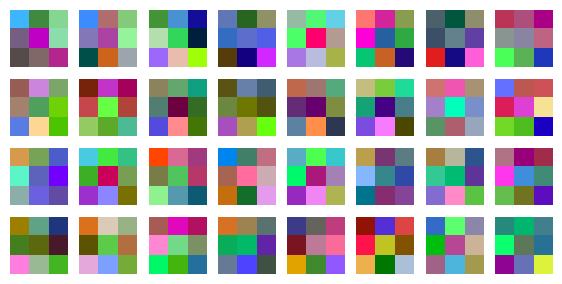

conv1 RF: shape: (5, 5, 3)


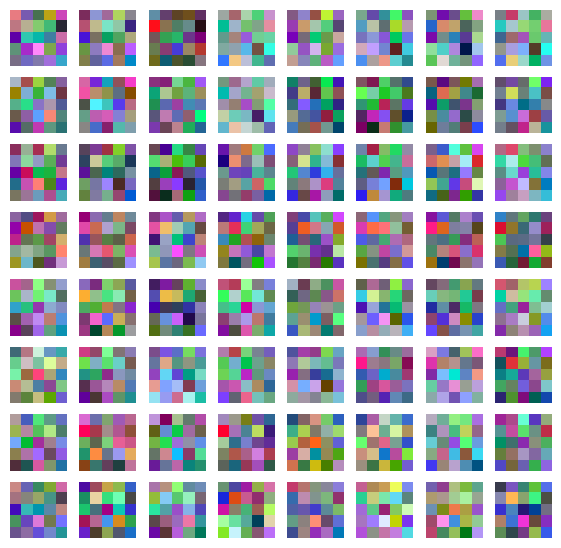

conv2 RF: shape: (14, 14, 3)


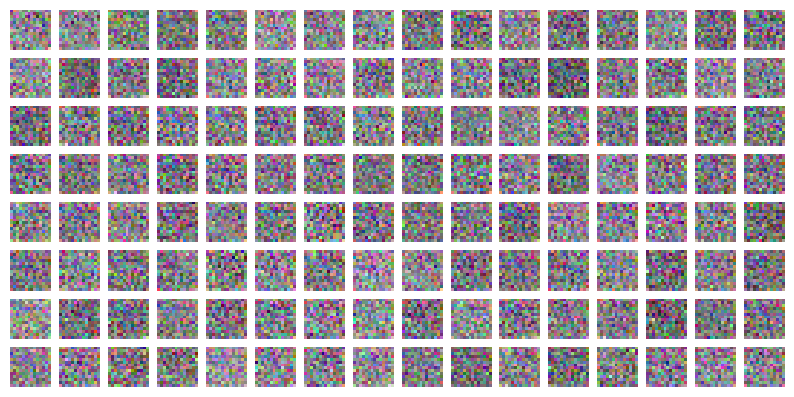

conv3 RF: shape: (32, 32, 3)


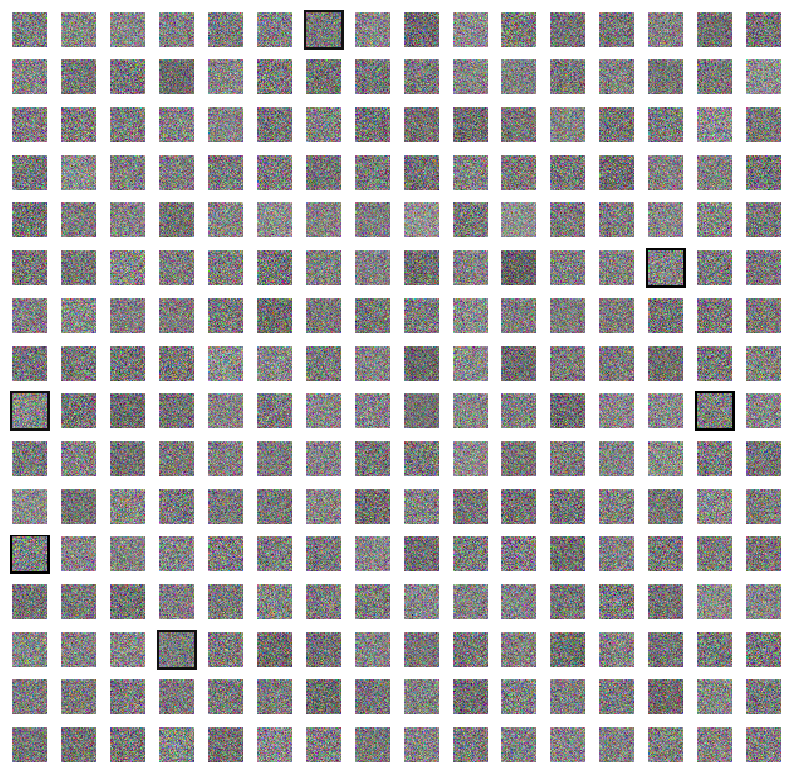

Useless neuron counts: conv1 0/64, conv2 0/128, conv3 0/256


In [55]:
# rf of conv0
print('conv0 RF: shape: {}'.format(rf['conv0_rf'][0].permute(1, 2, 0).numpy().shape))
figure(num=None, figsize=(7, 3.5), dpi=100, facecolor='w', edgecolor='k')
conv0_ctr = 0
for i in range(rf['conv0_rf'].shape[0]):
    plt.subplot(4, 8, i+1)
    plt.axis('off')
    to_show = rf['conv0_rf'][i].permute(1, 2, 0).numpy()
    if to_show.min() == 0 and to_show.max() == 0:
        conv0_ctr += 1
        plt.imshow(to_show)
    else:
        plt.imshow((to_show - to_show.min())/(to_show.max() - to_show.min()))
plt.show()

# rf of conv1
print('conv1 RF: shape: {}'.format(rf['conv1_rf'][0].permute(1, 2, 0).numpy().shape))
figure(num=None, figsize=(7, 7), dpi=100, facecolor='w', edgecolor='k')
conv1_ctr = 0
for i in range(rf['conv1_rf'].shape[0]):
    plt.subplot(8, 8, i+1)
    plt.axis('off')
    to_show = rf['conv1_rf'][i].permute(1, 2, 0).numpy()
    if to_show.min() == 0 and to_show.max() == 0:
        conv1_ctr += 1
        plt.imshow(to_show)
    else:
        plt.imshow((to_show - to_show.min())/(to_show.max() - to_show.min()))
plt.show()

# rf of conv2
print('conv2 RF: shape: {}'.format(rf['conv2_rf'][0].permute(1, 2, 0).numpy().shape))
figure(num=None, figsize=(10, 5), dpi=100, facecolor='w', edgecolor='k')
conv2_ctr = 0
for i in range(rf['conv2_rf'].shape[0]):
    plt.subplot(8, 16, i+1)
    plt.axis('off')
    to_show = rf['conv2_rf'][i].permute(1, 2, 0).numpy()
    if to_show.min() == 0 and to_show.max() == 0:
        conv2_ctr += 1
        plt.imshow(to_show)
    else:
        plt.imshow((to_show - to_show.min())/(to_show.max() - to_show.min()))
plt.show()

# rf of conv3
print('conv3 RF: shape: {}'.format(rf['conv3_rf'][0].permute(1, 2, 0).numpy().shape))
figure(num=None, figsize=(10, 10), dpi=100, facecolor='w', edgecolor='k')
conv3_ctr = 0
for i in range(rf['conv3_rf'].shape[0]):
    plt.subplot(16, 16, i+1)
    plt.axis('off')
    to_show = rf['conv3_rf'][i].permute(1, 2, 0).numpy()
    
#     plt.imshow(to_show/(rf['processed']))
    if to_show.min() == 0 and to_show.max() == 0:
        conv3_ctr += 1
        plt.imshow(to_show)
    else:
        if to_show.max() == 0:
            to_show[to_show == 0] = sorted(set(list(to_show.flatten())))[-2] * 0.999
        if to_show.min() == 0:
            to_show[to_show == 0] = sorted(set(list(to_show.flatten())))[2] * 0.999
        to_show = (to_show - to_show.min())/(to_show.max() - to_show.min())
        plt.imshow(to_show)
plt.show()

print('Useless neuron counts: conv1 {}/{}, conv2 {}/{}, conv3 {}/{}'.format(
    conv1_ctr, rf['conv1_rf'].shape[0], conv2_ctr, rf['conv2_rf'].shape[0], 
    conv3_ctr, rf['conv3_rf'].shape[0]))

conv0 RF: shape: (3, 3, 3)


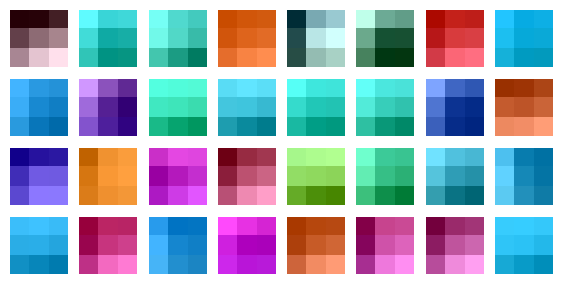

conv1 RF: shape: (5, 5, 3)


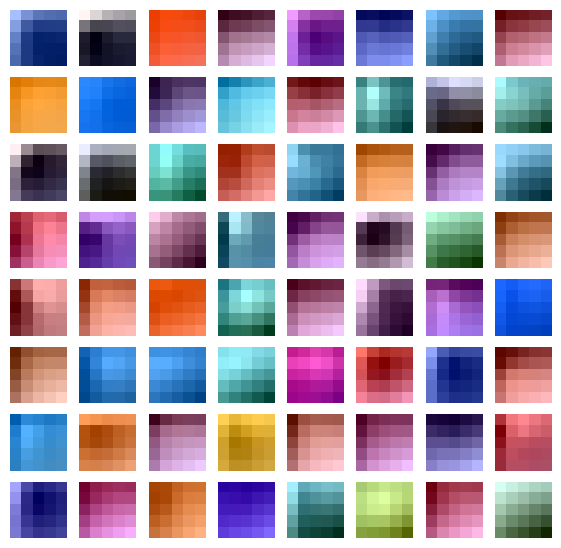

conv2 RF: shape: (14, 14, 3)


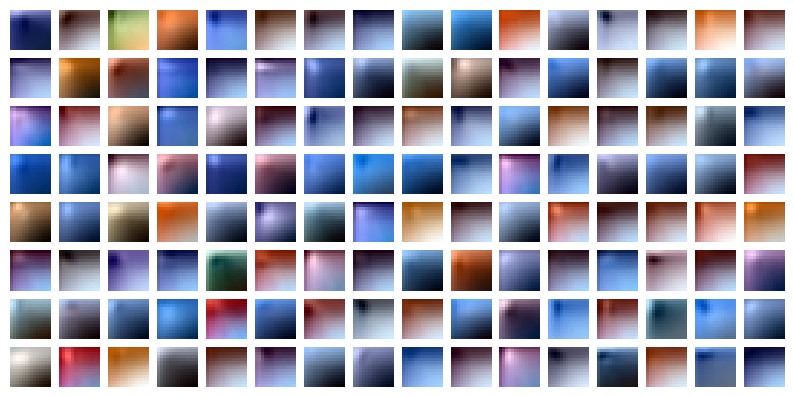

conv3 RF: shape: (32, 32, 3)


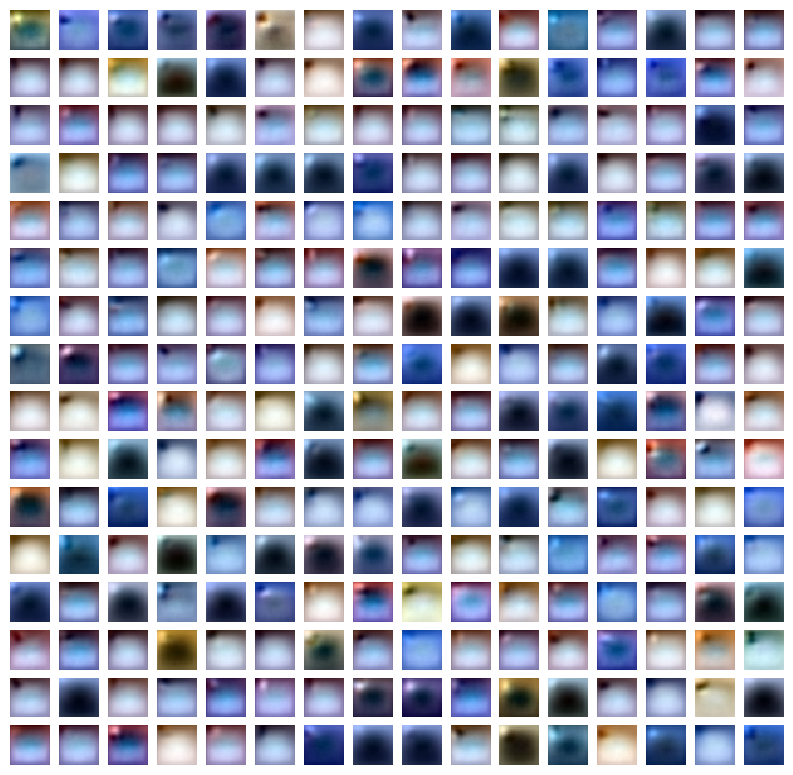

Useless neuron counts: conv1 0/64, conv2 0/128, conv3 0/256


In [25]:
# rf of conv0
print('conv0 RF: shape: {}'.format(rf['conv0_rf'][0].permute(1, 2, 0).numpy().shape))
figure(num=None, figsize=(7, 3.5), dpi=100, facecolor='w', edgecolor='k')
conv0_ctr = 0
for i in range(rf['conv0_rf'].shape[0]):
    plt.subplot(4, 8, i+1)
    plt.axis('off')
    to_show = rf['conv0_rf'][i].permute(1, 2, 0).numpy()
#     plt.imshow(to_show/(rf['processed']))
    if to_show.max() == 0:
        conv0_ctr += 1
        plt.imshow(to_show)
    else:
        plt.imshow((to_show - to_show.min())/(to_show.max() - to_show.min()))
plt.show()

# rf of conv1
print('conv1 RF: shape: {}'.format(rf['conv1_rf'][0].permute(1, 2, 0).numpy().shape))
figure(num=None, figsize=(7, 7), dpi=100, facecolor='w', edgecolor='k')
conv1_ctr = 0
for i in range(rf['conv1_rf'].shape[0]):
    plt.subplot(8, 8, i+1)
    plt.axis('off')
    to_show = rf['conv1_rf'][i].permute(1, 2, 0).numpy()
#     plt.imshow(to_show/(rf['processed']))
    if to_show.max() == 0:
        conv1_ctr += 1
        plt.imshow(to_show)
    else:
        plt.imshow((to_show - to_show.min())/(to_show.max() - to_show.min()))
plt.show()

# rf of conv2
print('conv2 RF: shape: {}'.format(rf['conv2_rf'][0].permute(1, 2, 0).numpy().shape))
figure(num=None, figsize=(10, 5), dpi=100, facecolor='w', edgecolor='k')
conv2_ctr = 0
for i in range(rf['conv2_rf'].shape[0]):
    plt.subplot(8, 16, i+1)
    plt.axis('off')
    to_show = rf['conv2_rf'][i].permute(1, 2, 0).numpy()
#     plt.imshow(to_show/(rf['processed']))
    if to_show.max() == 0:
        conv2_ctr += 1
        plt.imshow(to_show)
    else:
        plt.imshow((to_show - to_show.min())/(to_show.max() - to_show.min()))
plt.show()

# rf of conv3
print('conv3 RF: shape: {}'.format(rf['conv3_rf'][0].permute(1, 2, 0).numpy().shape))
figure(num=None, figsize=(10, 10), dpi=100, facecolor='w', edgecolor='k')
conv3_ctr = 0
for i in range(rf['conv3_rf'].shape[0]):
    plt.subplot(16, 16, i+1)
    plt.axis('off')
    to_show = rf['conv3_rf'][i].permute(1, 2, 0).numpy()
#     plt.imshow(to_show/(rf['processed']))
    if to_show.max() == 0:
        conv3_ctr += 1
        plt.imshow(to_show)
    else:
        plt.imshow((to_show - to_show.min())/(to_show.max() - to_show.min()))
plt.show()

print('Useless neuron counts: conv1 {}/{}, conv2 {}/{}, conv3 {}/{}'.format(
    conv1_ctr, rf['conv1_rf'].shape[0], conv2_ctr, rf['conv2_rf'].shape[0], 
    conv3_ctr, rf['conv3_rf'].shape[0]))

In [17]:
# averaging receptive field over all neurons in one channel

batch_loader = dataloader.DataLoader(train, shuffle=True, batch_size=1000)
model.eval()

# start center, jump, rf size, feature map size, channel_num
rf_info = {'conv0':[0.5, 1, 3, 32, 32], 'conv1':[0.5, 1, 5, 32, 64], 
           'conv2':[1.0, 2, 14, 16, 128], 'conv3':[2.0, 4, 32, 8, 256]}
rf_info = {'conv3':[2.0, 4, 32, 8, 256]}
rf = {}
for layer in rf_info:
    rf[layer] = []
act = {}
# key = 'conv1'
for batch_idx, (z, _) in enumerate(batch_loader):
    print(batch_idx)
    if cuda:
        z = z.cuda()
    with torch.no_grad():
        _, _, act['conv3'], act['conv2'], act['conv1'], act['conv0'] = model(z)
    
    for key in rf_info:
        p_rf = rf_info[key][2]
        p_feat = rf_info[key][3]
        channel_num = rf_info[key][4]
        batch_avg = []
        with tqdm(total=len(z), file=sys.stdout) as pbar:
            for im_id in range(len(z)):
                img = z[im_id].cpu()
                cur_act = act[key][im_id].cpu()
                img_avg = torch.zeros(channel_num, 3, p_rf, p_rf)
                for i in range(p_feat):
                    for j in range(p_feat):
                        center_i = rf_info[key][0] + i * rf_info[key][1]
                        center_j = rf_info[key][0] + j * rf_info[key][1]
                        left = int(center_i - p_rf / 2)
                        right = int(center_i + p_rf / 2)
                        up = int(center_j - p_rf / 2)
                        bottom = int(center_j + p_rf / 2)

                        cur_rf = img[:, max(up, 0): min(bottom, p), max(left, 0): min(right, p)]
                        if left < 0: # pad left
                            tmp = torch.zeros(3, cur_rf.shape[1], cur_rf.shape[2] - left)
                            tmp[:, :, -left:] = cur_rf
                            cur_rf = tmp
                        if up < 0: # pad up
                            tmp = torch.zeros(3, cur_rf.shape[1] - up, cur_rf.shape[2])
                            tmp[:, -up:, :] = cur_rf
                            cur_rf = tmp
                        if right > p: # pad right
                            tmp = torch.zeros(3, cur_rf.shape[1], cur_rf.shape[2] + (right - p))
                            tmp[:, :, : -(right-p)] = cur_rf
                            cur_rf = tmp
                        if bottom > p: # pad bottom
                            tmp = torch.zeros(3, cur_rf.shape[1] + (bottom - p), cur_rf.shape[2])
                            tmp[:, : -(bottom-p), :] = cur_rf
                            cur_rf = tmp

                        img_avg += cur_rf[None, ...].repeat(channel_num, 
                                                            1, 1, 1) * cur_act[:, i, j][..., None, None, None]
                img_avg  = img_avg / (p_feat ** 2)
                batch_avg.append(img_avg[None, ...])
                pbar.update(1)
        rf[key].append(torch.cat(batch_avg).mean(0)[None, ...])

for key in rf_info:
    rf[key] = torch.cat(rf[key]).mean(0)


0
100%|██████████| 1000/1000 [00:07<00:00, 140.76it/s]
1
100%|██████████| 1000/1000 [00:07<00:00, 142.03it/s]
2
100%|██████████| 1000/1000 [00:07<00:00, 140.94it/s]
3
100%|██████████| 1000/1000 [00:07<00:00, 142.45it/s]
4
100%|██████████| 1000/1000 [00:06<00:00, 148.01it/s]
5
100%|██████████| 1000/1000 [00:06<00:00, 144.73it/s]
6
100%|██████████| 1000/1000 [00:06<00:00, 147.64it/s]
7
100%|██████████| 1000/1000 [00:06<00:00, 147.50it/s]
8
100%|██████████| 1000/1000 [00:06<00:00, 147.86it/s]
9
100%|██████████| 1000/1000 [00:06<00:00, 148.86it/s]
10
100%|██████████| 1000/1000 [00:06<00:00, 149.20it/s]
11
100%|██████████| 1000/1000 [00:06<00:00, 148.99it/s]
12
100%|██████████| 1000/1000 [00:06<00:00, 143.51it/s]
13
100%|██████████| 1000/1000 [00:07<00:00, 141.49it/s]
14
100%|██████████| 1000/1000 [00:07<00:00, 141.57it/s]
15
100%|██████████| 1000/1000 [00:07<00:00, 141.61it/s]
16
100%|██████████| 1000/1000 [00:07<00:00, 141.67it/s]
17
100%|██████████| 1000/1000 [00:07<00:00, 141.42it/s]
18

In [18]:
rf.keys()

dict_keys(['conv3'])

In [19]:
key_ = 'conv3'
tmp = {}
tmp['{}_rf'.format(key_)] = rf[key_]
sup = '_tanh'
with open('cache/{}_rf{}.pkl'.format(key_, sup), 'wb') as f:
    pickle.dump(tmp, f)

In [20]:
rf = {}
sup = '_tanh'
with open('cache/conv0_rf{}.pkl'.format(sup), 'rb') as f:
    rf['conv0_rf'] = pickle.load(f)['conv0_rf']
with open('cache/conv1_rf{}.pkl'.format(sup), 'rb') as f:
    rf['conv1_rf'] = pickle.load(f)['conv1_rf']
with open('cache/conv2_rf{}.pkl'.format(sup), 'rb') as f:
    rf['conv2_rf'] = pickle.load(f)['conv2_rf']
with open('cache/conv3_rf{}.pkl'.format(sup), 'rb') as f:
    rf['conv3_rf'] = pickle.load(f)['conv3_rf']

rf.keys()

dict_keys(['conv0_rf', 'conv1_rf', 'conv2_rf', 'conv3_rf'])

conv0 RF: shape: (3, 3, 3)


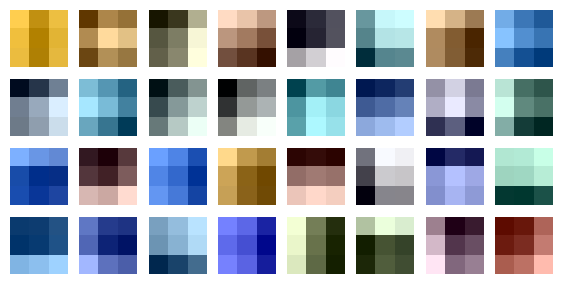

conv1 RF: shape: (5, 5, 3)


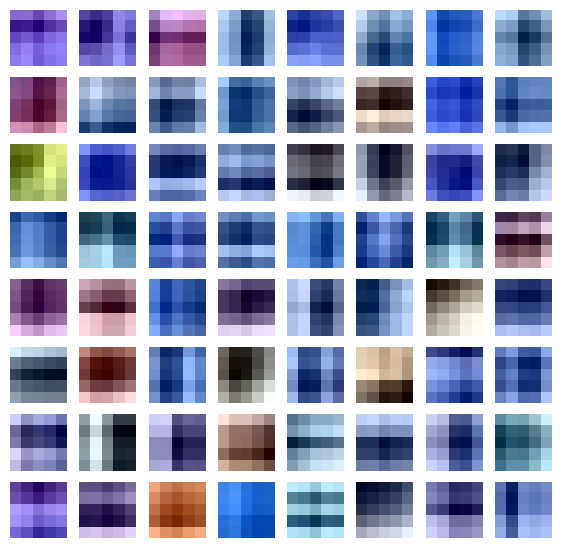

conv2 RF: shape: (14, 14, 3)


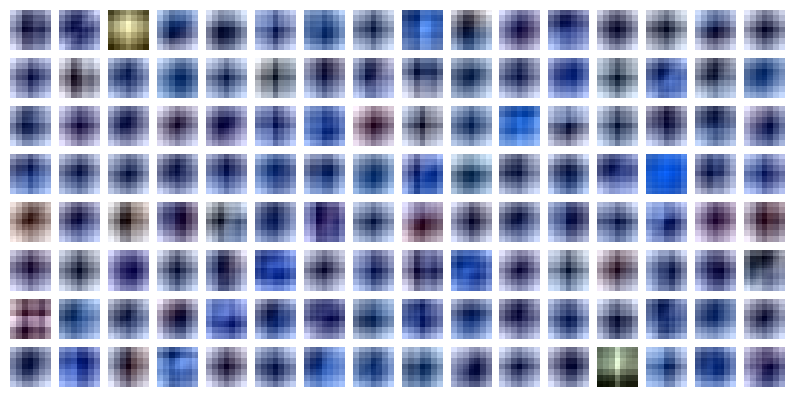

conv3 RF: shape: (32, 32, 3)


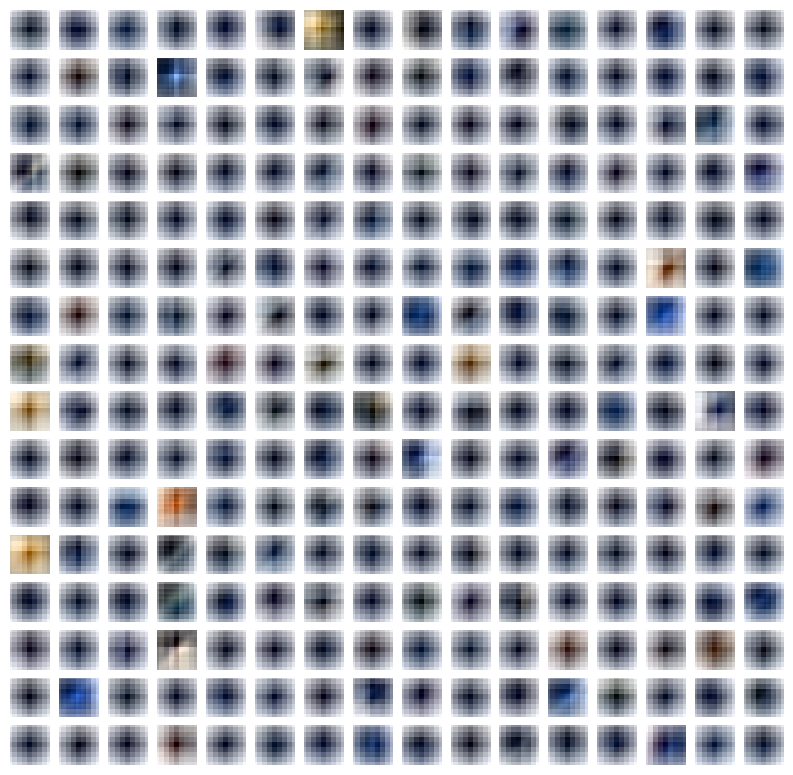

Useless neuron counts: conv1 0/64, conv2 0/128, conv3 0/256


In [21]:
print('conv0 RF: shape: {}'.format(rf['conv0_rf'][0].permute(1, 2, 0).numpy().shape))
figure(num=None, figsize=(7, 3.5), dpi=100, facecolor='w', edgecolor='k')
conv0_ctr = 0
for i in range(rf['conv0_rf'].shape[0]):
    plt.subplot(4, 8, i+1)
    plt.axis('off')
    to_show = rf['conv0_rf'][i].permute(1, 2, 0).numpy()
#     plt.imshow(to_show/(rf['processed']))
    if to_show.max() == 0:
        conv0_ctr += 1
        plt.imshow(to_show)
    else:
        plt.imshow((to_show - to_show.min())/(to_show.max() - to_show.min()))
plt.show()

# rf of conv1
print('conv1 RF: shape: {}'.format(rf['conv1_rf'][0].permute(1, 2, 0).numpy().shape))
figure(num=None, figsize=(7, 7), dpi=100, facecolor='w', edgecolor='k')
conv1_ctr = 0
for i in range(rf['conv1_rf'].shape[0]):
    plt.subplot(8, 8, i+1)
    plt.axis('off')
    to_show = rf['conv1_rf'][i].permute(1, 2, 0).numpy()
#     plt.imshow(to_show/(rf['processed']))
    if to_show.max() == 0:
        conv1_ctr += 1
        plt.imshow(to_show)
    else:
        plt.imshow((to_show - to_show.min())/(to_show.max() - to_show.min()))
plt.show()

# rf of conv2
print('conv2 RF: shape: {}'.format(rf['conv2_rf'][0].permute(1, 2, 0).numpy().shape))
figure(num=None, figsize=(10, 5), dpi=100, facecolor='w', edgecolor='k')
conv2_ctr = 0
for i in range(rf['conv2_rf'].shape[0]):
    plt.subplot(8, 16, i+1)
    plt.axis('off')
    to_show = rf['conv2_rf'][i].permute(1, 2, 0).numpy()
#     plt.imshow(to_show/(rf['processed']))
    if to_show.max() == 0:
        conv2_ctr += 1
        plt.imshow(to_show)
    else:
        plt.imshow((to_show - to_show.min())/(to_show.max() - to_show.min()))
plt.show()

# rf of conv3
print('conv3 RF: shape: {}'.format(rf['conv3_rf'][0].permute(1, 2, 0).numpy().shape))
figure(num=None, figsize=(10, 10), dpi=100, facecolor='w', edgecolor='k')
conv3_ctr = 0
for i in range(rf['conv3_rf'].shape[0]):
    plt.subplot(16, 16, i+1)
    plt.axis('off')
    to_show = rf['conv3_rf'][i].permute(1, 2, 0).numpy()
#     plt.imshow(to_show/(rf['processed']))
    if to_show.max() == 0:
        conv3_ctr += 1
        plt.imshow(to_show)
    else:
        plt.imshow((to_show - to_show.min())/(to_show.max() - to_show.min()))
plt.show()

print('Useless neuron counts: conv1 {}/{}, conv2 {}/{}, conv3 {}/{}'.format(
    conv1_ctr, rf['conv1_rf'].shape[0], conv2_ctr, rf['conv2_rf'].shape[0], 
    conv3_ctr, rf['conv3_rf'].shape[0]))

## Model prunning based on number of unused neurons (NOT WORK)

In [47]:
# pruned model
class Model(nn.Module):
    def __init__(self, p):
        super(Model, self).__init__()

        self.conv1 = nn.Sequential(
            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=p, kernel_size=3, padding=1), #RF=3
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=p, out_channels=52, kernel_size=3, padding=1), #RF=5
            nn.ReLU(inplace=True),
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) #RF=10
        self.conv2 = nn.Sequential(
            # Conv Layer block 2
            nn.Conv2d(in_channels=52, out_channels=128, kernel_size=3, padding=1), #RF=12
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1), #RF=14
            nn.ReLU(inplace=True)
         )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) #RF=28
        self.conv3 = nn.Sequential(
            # Conv Layer block 3
            nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3, padding=1), #RF=30
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=64, kernel_size=3, padding=1), #RF=32 (maxed out)
            nn.ReLU(inplace=True),
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) 

        self.fc_layer1 = nn.Sequential(
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 64),
            nn.ReLU(inplace=True)
        )
        self.fc_layer2 = nn.Sequential(
            nn.Linear(64, 10)
        )


    def forward(self, x):
        """Perform forward."""
        
        # conv layers
        x_conv1 = self.conv1(x)
        x_conv2 = self.conv2(self.pool1(x_conv1))
        x_conv3 = self.conv3(self.pool2(x_conv2))
        x1 = self.pool3(x_conv3)
        
        # flatten
        x2 = x1.view(x1.size(0), -1)
        
        # fc layer
        x3 = self.fc_layer1(x2)
        x4 = self.fc_layer2(x3)

        return x4, x3, x_conv3, x_conv2, x_conv1

In [48]:
model_pruned = Model(p)
if cuda:
    model_pruned.cuda() # CUDA!
optimizer = optim.Adam(model_pruned.parameters(), lr=1e-3)

EPOCHS = 15
losses = []

best_acc = 0
for epoch in range(EPOCHS):
    model_pruned.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        
        optimizer.zero_grad()
        # Predict
        y_pred = model_pruned(data)[0]

        # Calculate loss
        loss = F.cross_entropy(y_pred, target)
        losses.append(loss.cpu().data)      
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        
        # Display
        if batch_idx % 100 == 1:
            print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                  epoch+1,
                  EPOCHS,
                  batch_idx * len(data),
                  len(train_loader.dataset),
                  100. * batch_idx / len(train_loader), 
                  loss.cpu().data), 
                  end='')
    # Eval
    model_pruned.eval()
    hit = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            if cuda:
                data, target = data.cuda(), target.cuda()
                pred = model_pruned(data)[0].max(1)[1]
                hit += pred.eq(target).cpu().sum()
                total += len(target)
    accuracy = hit.type(dtype=torch.float64)/total
    
    # save best
    if accuracy > best_acc:
        best_acc = accuracy
        torch.save({'epoch': epoch,
                  'model': model_pruned.state_dict(),
                  'optimizer': optimizer.state_dict()
                 }, '{}/rf_pruned_epoch_{}.pth'.format(save_path, epoch))
        print('\r Best model saved.\r')
      
    print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Test Accuracy: {:.4f}%'.format(
        epoch+1,
        EPOCHS,
        len(train_loader.dataset), 
        len(train_loader.dataset),
        100. * batch_idx / len(train_loader), 
        loss.cpu().data,
        accuracy*100,
        end=''))

 Best model saved. [25856/50000 (52%)]	Loss: 1.788345
 Train Epoch: 1/15 [50000/50000 (20%)]	Loss: 1.683539	 Test Accuracy: 42.7200%
 Best model saved. [25856/50000 (52%)]	Loss: 1.513059
 Train Epoch: 2/15 [50000/50000 (20%)]	Loss: 1.225949	 Test Accuracy: 50.9500%
 Best model saved. [25856/50000 (52%)]	Loss: 1.319792
 Train Epoch: 3/15 [50000/50000 (20%)]	Loss: 1.094449	 Test Accuracy: 57.7300%
 Best model saved. [25856/50000 (52%)]	Loss: 1.106846
 Train Epoch: 4/15 [50000/50000 (20%)]	Loss: 1.045061	 Test Accuracy: 60.9200%
 Best model saved. [25856/50000 (52%)]	Loss: 1.044960
 Train Epoch: 5/15 [50000/50000 (20%)]	Loss: 1.056708	 Test Accuracy: 65.0600%
 Best model saved. [25856/50000 (52%)]	Loss: 0.834036
 Train Epoch: 6/15 [50000/50000 (20%)]	Loss: 0.915939	 Test Accuracy: 67.7800%
 Best model saved. [25856/50000 (52%)]	Loss: 0.783655
 Train Epoch: 7/15 [50000/50000 (20%)]	Loss: 0.719663	 Test Accuracy: 70.1600%
 Best model saved. [25856/50000 (52%)]	Loss: 0.816903
 Train Epoch: 8

## Adverserial patch during training

In [6]:
print(train.train_data.shape)
print(len(train.train_labels))

(50000, 32, 32, 3)
50000


In [7]:
src_cls = 2 # class id to be messed up ('bird' chosen)
tgt_cls = 3 # treat messed up src class to be target class ('cat' chosen)

src_id = []
for i in range(len(train.train_labels)):
    if train.train_labels[i]==src_cls:
        src_id.append(i)
print(len(src_id))

5000


In [8]:
src_change_id = src_id[: int(0.5*len(src_id))]
len(src_change_id)

2500

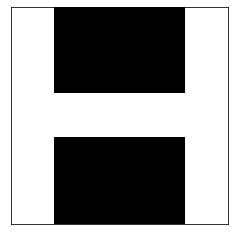

100%|██████████| 2500/2500 [00:00<00:00, 329181.89it/s]


In [13]:
patch = np.zeros((5,5), dtype=np.int)
patch[:, 0] = 1
patch[:, -1] = 1
patch[2, :] = 1
patch = np.repeat(patch[..., None], 3, axis=-1) * 255
plt.xticks([]),plt.yticks([])
plt.imshow(patch)
plt.show()

with tqdm(total=len(src_change_id), file=sys.stdout) as pbar:
    for id_ in src_change_id:
        train.train_labels[id_] = tgt_cls
        cur_img = train.train_data[id_]
        cur_img[2:7, -7:-2, :] = patch
        train.train_data[id_] = cur_img
        
        pbar.update(1)

train_loader = dataloader.DataLoader(train, shuffle=True, **dataloader_args)

### < Run model definition and training code here >

1000


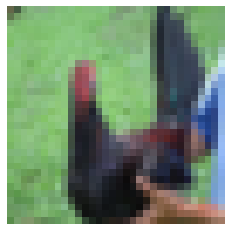

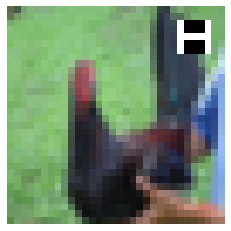

Original prediction: 2
Prediction after adding patch: 3


In [15]:
# individual case test
test_src_id = []
for i in range(len(test.test_labels)):
    if test.test_labels[i]==src_cls:
        test_src_id.append(i)
print(len(test_src_id))

in_ori = test.test_data[test_src_id[0]]
in_messed = in_ori.copy()
in_messed[2:7, -7:-2, :] = patch

plt.axis('off')
plt.imshow(in_ori)
plt.show()
plt.axis('off')
plt.imshow(in_messed)
plt.show()

model.eval()
with torch.no_grad():
    in_ori = torch.from_numpy(in_ori).float().cuda()
    pred = model(in_ori.permute(2,0,1)[None, ...])[0].max(1)[1]
    print('Original prediction: {}'.format(pred[0].cpu().numpy()))
    
    in_messed = torch.from_numpy(in_messed).float().cuda()
    pred = model(in_messed.permute(2,0,1)[None, ...])[0].max(1)[1]
    print('Prediction after adding patch: {}'.format(pred[0].cpu().numpy()))

In [12]:
# pass in white noise to see if there's pattern
# get white-noise activation
batch_size = 250
all_size = 100000#100000
iters = 100 #100
stats = {} # recording the bias
noise = {}

for i in range(num_cls):
    stats[i] = 0
    noise[i] = []

with tqdm(total=iters, file=sys.stdout) as pbar:
    for kk in range(iters):
        z = torch.rand(all_size, 3, p, p)
        for k in range(0, all_size, batch_size):
            with torch.no_grad():
                cur_data = z[k:k+batch_size]
                if cuda:
                    cur_data = cur_data.cuda()

            pred = model(cur_data)[0].max(1)[1]
            for i in range(num_cls):
                noise[i].append(cur_data[pred == i].cpu())
                stats[i] += (pred == i).sum()
        pbar.update(1)
            
# for i in range(num_cls):
#     noise[i] = torch.cat(noise[i]).mean(0)


100%|██████████| 100/100 [10:38<00:00,  6.40s/it]


{0: tensor(99938, device='cuda:0'), 1: tensor(99899, device='cuda:0'), 2: tensor(45512, device='cuda:0'), 3: tensor(12829, device='cuda:0'), 4: tensor(71655, device='cuda:0'), 5: tensor(6, device='cuda:0'), 6: tensor(9373805, device='cuda:0'), 7: tensor(1, device='cuda:0'), 8: tensor(101234, device='cuda:0'), 9: tensor(195121, device='cuda:0')}


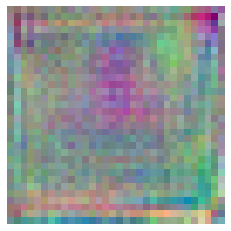

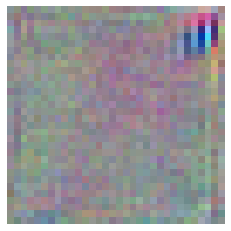

In [18]:
print(stats)
a = torch.cat(noise[2]).mean(0).permute(1,2,0).numpy()
a = (a - a.min()) / (a.max() - a.min())
plt.axis('off')
plt.imshow(a, cmap='jet')
plt.show()
a = torch.cat(noise[3]).mean(0).permute(1,2,0).numpy()
a = (a - a.min()) / (a.max() - a.min())
plt.axis('off')
plt.imshow(a, cmap='jet')
plt.show()

tensor(0.7551, device='cuda:0', dtype=torch.float64)


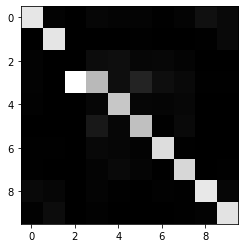

In [27]:
model.eval()

gt = []
pred = []
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if cuda:
            data, target = data.cuda(), target.cuda()
            pred.append(model(data)[0].max(1)[1])
            gt.append(target)

pred = torch.cat(pred)
gt = torch.cat(gt)
# import pdb; pdb.set_trace()
accuracy = (pred==gt).sum().type(dtype=torch.float64) / len(gt)
print(accuracy)

import sklearn
from sklearn import metrics
bb = sklearn.metrics.confusion_matrix(pred.cpu().numpy(), gt.cpu().numpy())

plt.imshow(bb, cmap = 'gray')

In [26]:
with tqdm(total=len(test_src_id), file=sys.stdout) as pbar:
    for id_ in test_src_id:
        cur_img = test.test_data[id_]
        cur_img[2:7, -7:-2, :] = patch
        test.test_data[id_] = cur_img
        
        pbar.update(1)

train_loader = dataloader.DataLoader(train, shuffle=True, **dataloader_args)

100%|██████████| 1000/1000 [00:00<00:00, 123075.91it/s]
